In [62]:
using Plots
using SparseArrays
using Random
using Combinatorics
using LinearAlgebra, Test
using Arpack
using LaTeXStrings
using LinearAlgebra

include("unitTests.jl")

testtttt (generic function with 1 method)

In [242]:
# Method to construct 1D Hamiltonian of spinless hardcore bosons with nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_nearest_neighbor(N, J, h, t, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)

    if(method=="full")
        H=zeros(Float64, 2^(N), 2^(N));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the states in the computational basis
    for i=0:2^(N)-1
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi(0, i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0
            if(!pbc && j==N)
                continue
            end
            # flip the occupation at site j, then i
            if(occupation + occupation_next == 1)
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i))        
                # push the hopping energy to the off-diagonal element
                push!(rows, i+1)
                push!(cols, hopping_state+1)
                push!(values, -t[j]/2)

                push!(rows, hopping_state+1)
                push!(cols, i+1)
                push!(values, -t[j]/2)


                if(i<hopping_state)
                    push!(index_list[j], (i+1, hopping_state+1))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state+1, i+1]-=t[j]/2;
                    H[i+1,hopping_state+1]-=t[j]/2;
                end
            end
        end
        push!(rows, i+1);
        push!(cols, i+1);
        push!(values, energy_of_i)
        if(method=="full")
            H[i+1, i+1]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_nearest_neighbor (generic function with 3 methods)

In [3]:
# Method to construct 1D Hamiltonian of spinless hardcore bosons with nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_next_nearest_neighbor(N, J, h, t, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)

    if(method=="full")
        H=zeros(Float64, 2^(N), 2^(N));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the states in the computational basis
    for i=0:2^(N)-1
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site

            occupation_next=getTi(j+1 , i)
            if(j+2<=N)
                # note that j is index 1 while getTi takes index 0
                occupation_next=getTi(j+1, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi((j+2)%(N+1) , i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0
            if(!pbc && j==N)
                continue
            end

            # occupation at the neighboring site
            occupation_next_hopping=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next_hopping=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next_hopping=getTi(0, i)               
                end
            end
            
            # flip the occupation at site j, then i
            if(occupation + occupation_next_hopping == 1)
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i))        
                # push the hopping energy to the off-diagonal element
                push!(rows, i+1)
                push!(cols, hopping_state+1)
                push!(values, -t[j]/2)

                push!(rows, hopping_state+1)
                push!(cols, i+1)
                push!(values, -t[j]/2)

                if(i<hopping_state)
                    push!(index_list[j], (i+1, hopping_state+1))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state+1, i+1]-=t[j]/2;
                    H[i+1,hopping_state+1]-=t[j]/2;
                end
            end
        end
        push!(rows, i+1);
        push!(cols, i+1);
        push!(values, energy_of_i)
        if(method=="full")
            H[i+1, i+1]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_next_nearest_neighbor (generic function with 3 methods)

In [4]:
function kbits(n::Int, k::Int)
    result = String[]
    for bits in combinations(1:n, k)
        s = fill('0', n)
        for bit in bits
            s[bit] = '1'
        end
        push!(result, join(s))
    end
    return result
end

# 
function construct_map_of_half_filling_states(L)
    temp=sort([parse(Int, x; base=2) for x in kbits(L, div(L, 2))], rev=false)
    dict=Dict{Int, Int}()
    count=1
    for t in temp
        dict[t]=count
        count+=1
    end
    return dict
end

# 
function construct_map_of_n_filling_states(L, n)
    temp=([parse(Int, x; base=2) for x in kbits(L, n)])
    dict=Dict{Int, Int}()
    count=1
    for t in temp
        dict[t]=count
        count+=1
    end
    return dict
end

# Method to construct 1D Hamiltonian of spinless hardcore bosons with nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(N, J, h, t, map_half_filling_states, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)
    all_states=collect(Base.keys(map_half_filling_states))
    #println(all_states)

    if(method=="full")
        H=zeros(Float64, (length(all_states)), (length(all_states)));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the computational basis states in the half-filling sector
    for i in all_states
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        i_index=map_half_filling_states[i]
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi(0, i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0

            if(!pbc && j==N)
                continue
            end
            # flip the occupation at site j, then i
            if(occupation + occupation_next == 1)
                # note that j is the next site
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i)) 

                hopping_state_index=map_half_filling_states[hopping_state]
                # push the hopping energy to the off-diagonal element
                push!(rows, i_index)
                push!(cols, hopping_state_index)
                push!(values, -t[j]/2)

                push!(rows, hopping_state_index)
                push!(cols, i_index)
                push!(values, -t[j]/2)

                if(i<hopping_state)
                    push!(index_list[j], (i_index, hopping_state_index))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state_index, i_index]-=t[j]/2;
                    H[i_index,hopping_state_index]-=t[j]/2;
                end
            end
        end
        push!(rows, i_index);
        push!(cols, i_index);
        push!(values, energy_of_i)
        if(method=="full")
            H[i_index, i_index]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling (generic function with 3 methods)

In [5]:
# Method to construct 1D Hamiltonian of spinless hardcore bosons with NEXT nearest neighbor interactions, hoppings, and onsite potentials h
# N is the number of sites
# J is the interaction energies (size N-1 if pbc=false, otherwise size N). J[j] is the interaction between j, j+1
# t: hoppings at each link, size N-1 if pbc=false, otherwise size N. t[j] is hopping between j and j+1
# computational basis
# pbc= true by default
# need to return list of largest off diagonal elements
# build a sparse Hamiltonian
function construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling(N, J, h, t, map_half_filling_states, pbc=true, method="full")
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];

    # get the off-diagonal terms with the largest coefficient
    max_index = argmax(t)
    all_states=collect(Base.keys(map_half_filling_states))
    #println(all_states)

    if(method=="full")
        H=zeros(Float64, (length(all_states)), (length(all_states)));
    end

    off_diags = zeros(Float64, N)

    # need to find all states that correspond to a particular hopping, and also store the largest of-diagonal element
    index_list = [[] for i=1:N]

    # Loop through all the computational basis states in the half-filling sector
    for i in all_states
        # Loop through all the sites
        # Keep track of the digaonal energy terms associated with this particular state 
        energy_of_i = 0
        i_index=map_half_filling_states[i]
        for j=1:N
            # First we deal with interactions
            # get the occupation at the jth position for the state i
            next_site=0

            # occupation at current site
            occupation=getTi(j-1, i)

            # occupation at the neighboring site
            occupation_next=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site

            occupation_next=getTi(j+1 , i)
            if(j+2<=N)
                # note that j is index 1 while getTi takes index 0
                occupation_next=getTi(j+1, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next=getTi((j+2)%(N+1) , i)               
                end
            end

            # the nearest neighbor interaction is the multiplication of the occupations and the interaction strength at link i J[i]
            energy_of_i += J[j]*occupation*occupation_next

            # We add onsite potentials
            energy_of_i += + h[j]*occupation

            # We now deal with hopping
            next_site = 0
            if(!pbc && j==N)
                continue
            end

            # occupation at the neighboring site
            occupation_next_hopping=0
            # get its neighbors occupation. If not PBC and last site, there's no neighbor. If PBC, it's neighbors with the first site
            if(j<N)
                occupation_next_hopping=getTi(j, i)
            else
                # if periodic boundary conditions, we get the first site
                if(pbc)
                    occupation_next_hopping=getTi(0, i)               
                end
            end
            
            # flip the occupation at site j, then i
            if(occupation + occupation_next_hopping == 1)
                # note that j is the next site
                next_ind = j == N ? 0 : j
                hopping_state = flipBit(next_ind, flipBit(j-1, i)) 

                hopping_state_index=map_half_filling_states[hopping_state]
                # push the hopping energy to the off-diagonal element
                push!(rows, i_index)
                push!(cols, hopping_state_index)
                push!(values, -t[j]/2)

                push!(rows, hopping_state_index)
                push!(cols, i_index)
                push!(values, -t[j]/2)

                if(i<hopping_state)
                    push!(index_list[j], (i_index, hopping_state_index))
                end
                
                # and the hermitian conjugate
                if(method=="full")
                    H[hopping_state_index, i_index]-=t[j]/2;
                    H[i_index,hopping_state_index]-=t[j]/2;
                end
            end
        end
        push!(rows, i_index);
        push!(cols, i_index);
        push!(values, energy_of_i)
        if(method=="full")
            H[i_index, i_index]=energy_of_i;
        end
    end
    
    if(method=="sparse")
            H=sparse(rows, cols, values);
    end

    return (H, index_list);
end

construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling (generic function with 3 methods)

In [6]:
# number operator at site j, j=1...N
# can rotate back to the original basis to see its structure
function get_number_operator(j, L)
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];
    for i=0:2^L-1
        occupation=getTi(j-1, i)
        if(occupation==1)
            push!(cols, i+1)
            push!(rows, i+1)
            push!(values, 1)
        end
    end
    return sparse(rows, cols, values)
end

function get_number_operator_dense(j, L)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        occupation=getTi(j-1, i)
        if(occupation==1)
            N[i+1, i+1] = 1
        end
    end
    return N
end

function get_total_number_operator(L)
    cols::Vector{Int}=Int[];
    rows::Vector{Int}=Int[];
    values::Vector{Float64}=Float64[];
    for i=0:2^L-1
        push!(cols, i+1)
        push!(rows, i+1)
        push!(values, countBits(n))
    end
    return sparse(rows, cols, values)
end

function get_total_number_operator_dense(L)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        N[i+1, i+1] = countBits(i)
    end
    return N
end

# includes the site at i_0
function get_N_R_operator(L, i_0)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        N[i+1, i+1] = countBits(i & (2^i_0 - 1))
    end
    return N
end

function get_N_R_operator(L, map, i_0)
    the_values=(collect(keys(map)))
    N=zeros(Float64, length(the_values), length(the_values))
    for i in the_values
        index=map[i]
        N[index, index] = countBits(i & (2^i_0 - 1))
    end
    return N
end

function get_N_L_operator(L, i_0)
    N=zeros(Float64, 2^L, 2^L)
    for i=0:2^L-1
        N[i+1, i+1] = countBits(i & ((2^i_0 - 1) << i_0 ))
    end
    return N
end

function get_N_L_operator(L, map, i_0)
    the_values=(collect(keys(map)))
    N=zeros(Float64, length(the_values), length(the_values))
    for i in the_values
        index=map[i]
        N[index, index] = countBits(i & ((2^i_0 - 1) << i_0 ))
    end
    return N
end

function get_N_R_operator_non_interacting(L, i_0)
    N=zeros(Float64, L, L)
    for i=1:L
        N[i, i] = i<=i_0 ? 1 : 0
    end
    return N
end

function get_N_R_operator_eigenstate_basis(L, eigenstates, i_0)
    N_R=get_N_R_operator(L, i_0)
    N_R=eigenstates'*N_R*eigenstates
    N_R=N_R-Diagonal(diag(N_R))
    return N_R
end

function get_N_R_operator_eigenstate_basis(L, the_map,eigenstates, i_0)
    N_R=get_N_R_operator(L,the_map, i_0)
    N_R=eigenstates'*N_R*eigenstates
    N_R=N_R-Diagonal(diag(N_R))
    return N_R
end


function get_N_R_operator_computational_basis(L, eigenstates, i_0)
        return
end

get_N_R_operator_computational_basis (generic function with 1 method)

# Helpers for quench experiment

In [7]:
# assume the eigenstates are in the computational basis for the half-filling sector
# prepares the state with all particles on the right in the eigenstate basis
function prepare_half_filling_state(eigenstates, map_states, L, i_0)
    # the binary number corresponding to 111...00
    half_filling_binary_no=2^(i_0)-1
    
    # the half filling state but rewritten in the eigenstate basis
    half_filling_state=[]
    index=map_states[half_filling_binary_no]
    for i=1:length(eigenstates[:, 1])
        push!(half_filling_state,eigenstates[index,i])
    end
    return half_filling_state
end

# prepares a state 000...111
function prepare_half_filling_state(eigenstates, map_states, L, i_0)
    # the binary number corresponding to 111...00
    half_filling_binary_no=2^(i_0)-1

    # index 1    
    # the half filling state but rewritten in the eigenstate basis
    half_filling_state=[]
    index=map_states[half_filling_binary_no]
    for i=1:length(eigenstates[:, 1])
        push!(half_filling_state,eigenstates[index,i])
    end
    return half_filling_state
end

# assumes "state" is written in the eigenbasis
# map_states is a map from state -> index. Fine as long as its consistent
function measure_number_particles_right_of_i_0(state, the_map, eigenstates, L, i_0)
    N_R=get_N_R_operator(L,the_map, i_0)
    N_R=eigenstates'*N_R*eigenstates
    return state' * N_R * state
end

function measure_number_particles_left_of_i_0(state, the_map, eigenstates, L, i_0)
    N_R=get_N_L_operator(L,the_map, i_0)
    N_R=eigenstates'*N_R*eigenstates
    return state' * N_R * state
end

measure_number_particles_left_of_i_0 (generic function with 1 method)

# Quench Experiment

In [660]:
# 500 disorder realizations
iterations=500
L= 10; # system size
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 10; # disorder strength
the_map=construct_map_of_n_filling_states(L, div(L,2))
d=Uniform(-1,1)
J_mag=0.1
i_0=div(L,2)
J = J_mag*ones(Float64, L); # interactions
maximum_particles_transported=[]
dynamical_upper_bound_all=[]
dynamical_upper_bound_all_2=[]

dynamical_average=[]
ctc=[]

max_time=10000

for i=1:iterations
    h=W*rand(d, L)
    H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
    eigtemp=eigen(H_half_filling);
    N_L=get_N_L_operator(L,the_map, i_0)
    N_L=eigtemp.vectors'*N_L*eigtemp.vectors
    particle_number=[]
    the_states=prepare_half_filling_state(eigtemp.vectors, the_map, L, i_0)

    N_R=get_N_L_operator(L,the_map, i_0)
    N_R=eigtemp.vectors'*N_R*eigtemp.vectors
    N_R_nodiag=N_R-Diagonal(diag(N_R))
    time_average=0
    for i=1:size(N_R, 1)
        time_average+=abs2(the_states[i])*N_R[i,i]
    end
    push!(dynamical_average, time_average)
    
    values, vecs, info=eigsolve(N_R_nodiag, 1, :SR; ishermitian=true);
    values_2, vecs, info=eigsolve(N_R_nodiag, 1, :LR; ishermitian=true);
    push!(ctc,(values_2[1]-values[1])/2)

    v = abs.(the_states)           # |ψ|
    A = abs.(N_R)                  # |N|
    tmp = similar(v)               # workspace
    mul!(tmp, A, v)                # tmp = A * v  (fast, BLAS / sparse matvec)
    dynamical_upper_bound = dot(v, tmp)
    push!(dynamical_upper_bound_all_2, dynamical_upper_bound)

    for t=0:10:max_time
        time_evolved=time_evolve_state(the_states, eigtemp.values, t)
        number_particles_left=measure_number_particles_left_of_i_0(time_evolved, the_map,eigtemp.vectors, L, i_0).re
        push!(particle_number, number_particles_left)
    end
    push!(maximum_particles_transported, maximum(particle_number))
end

#save_object("8_11_quench_experiment="*string(W)*", J="*string(J_mag)*", t="*string(T)*".jld2", all_data)

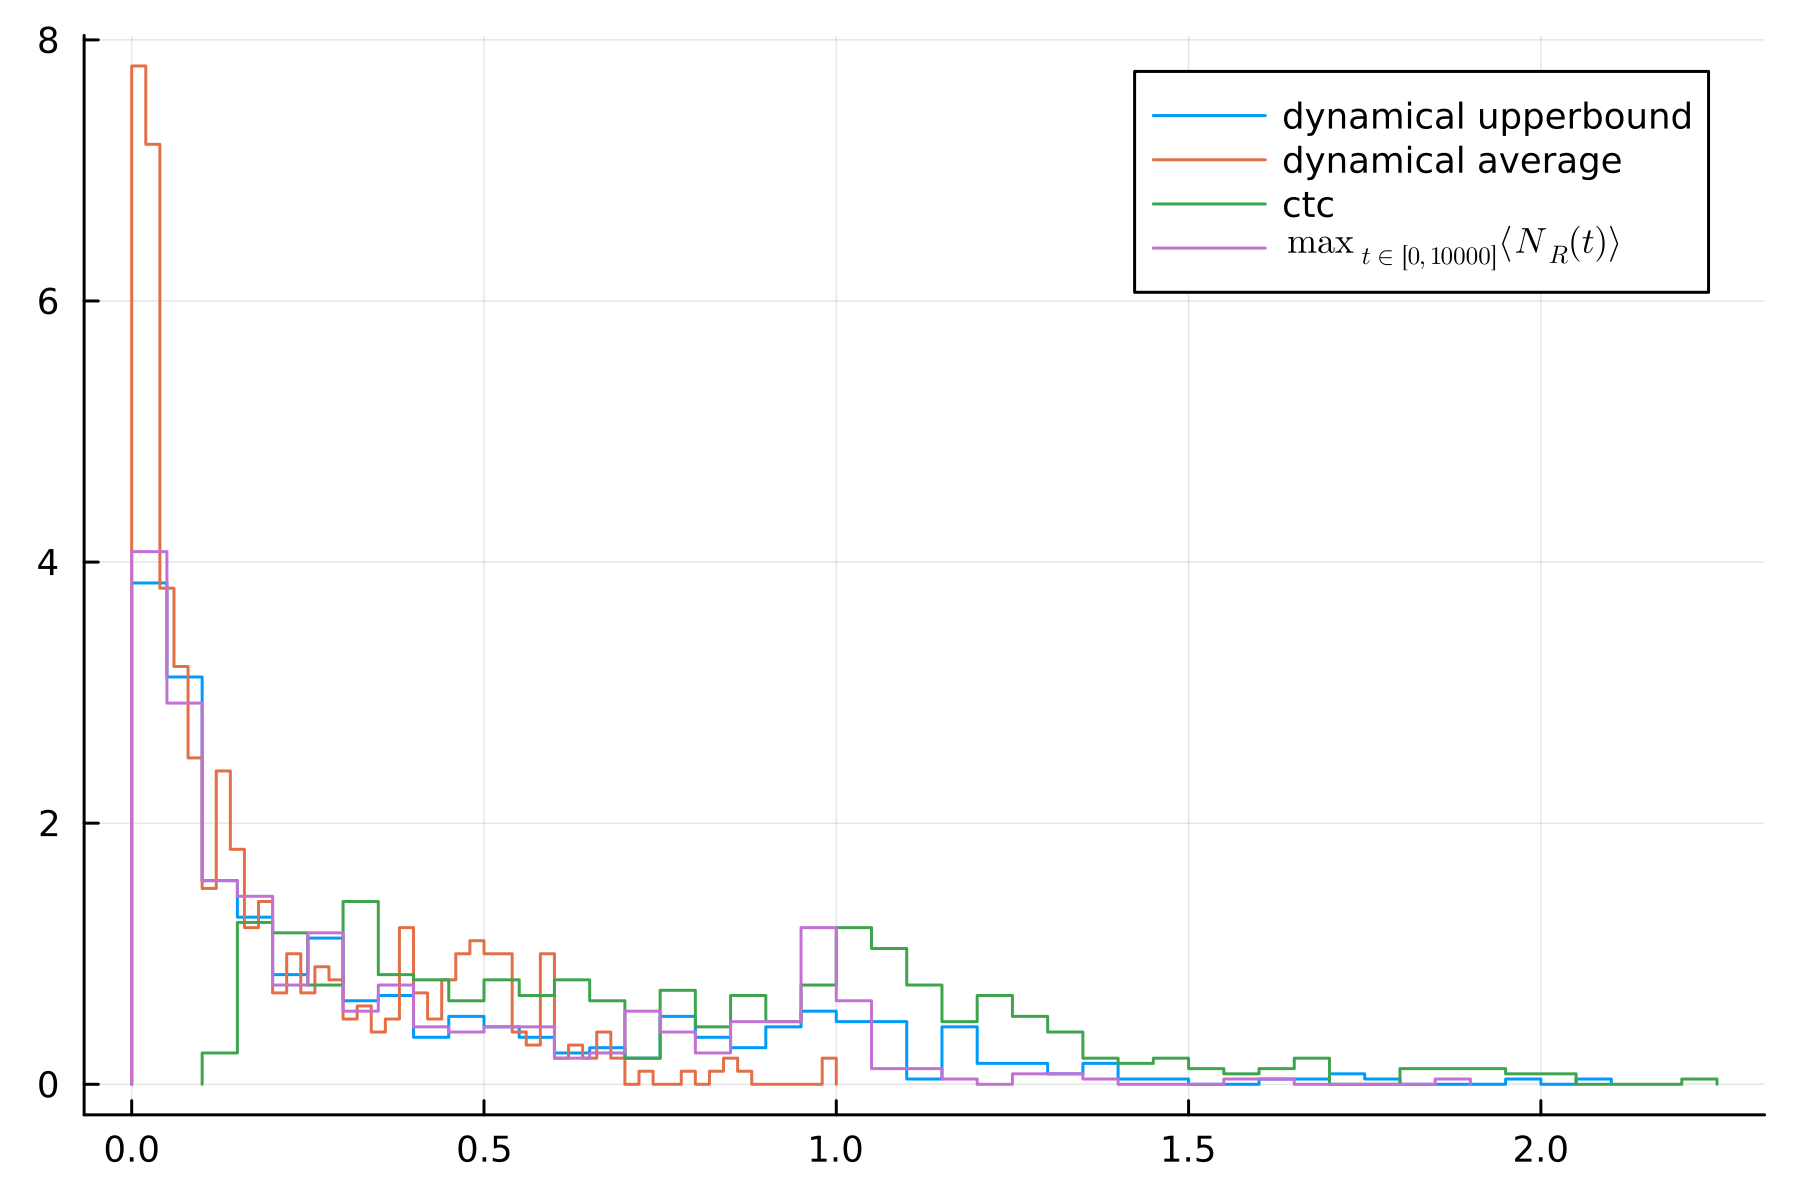

In [661]:
stephist(dynamical_upper_bound_all_2, label="dynamical upperbound", norm=true, bins=50)
stephist!(dynamical_average,label="dynamical average", norm=true, bins=50)
stephist!(2* ctc, label="ctc", norm=true, bins=50)
stephist!(maximum_particles_transported,label=L"\max_{t\in[0,10000]}{\langle N_R(t)\rangle}", norm=true, dpi=300, bins=50)
#savefig("step histogram CTC, dynamical upper bound,etc W=1, J=1, L=10.png")

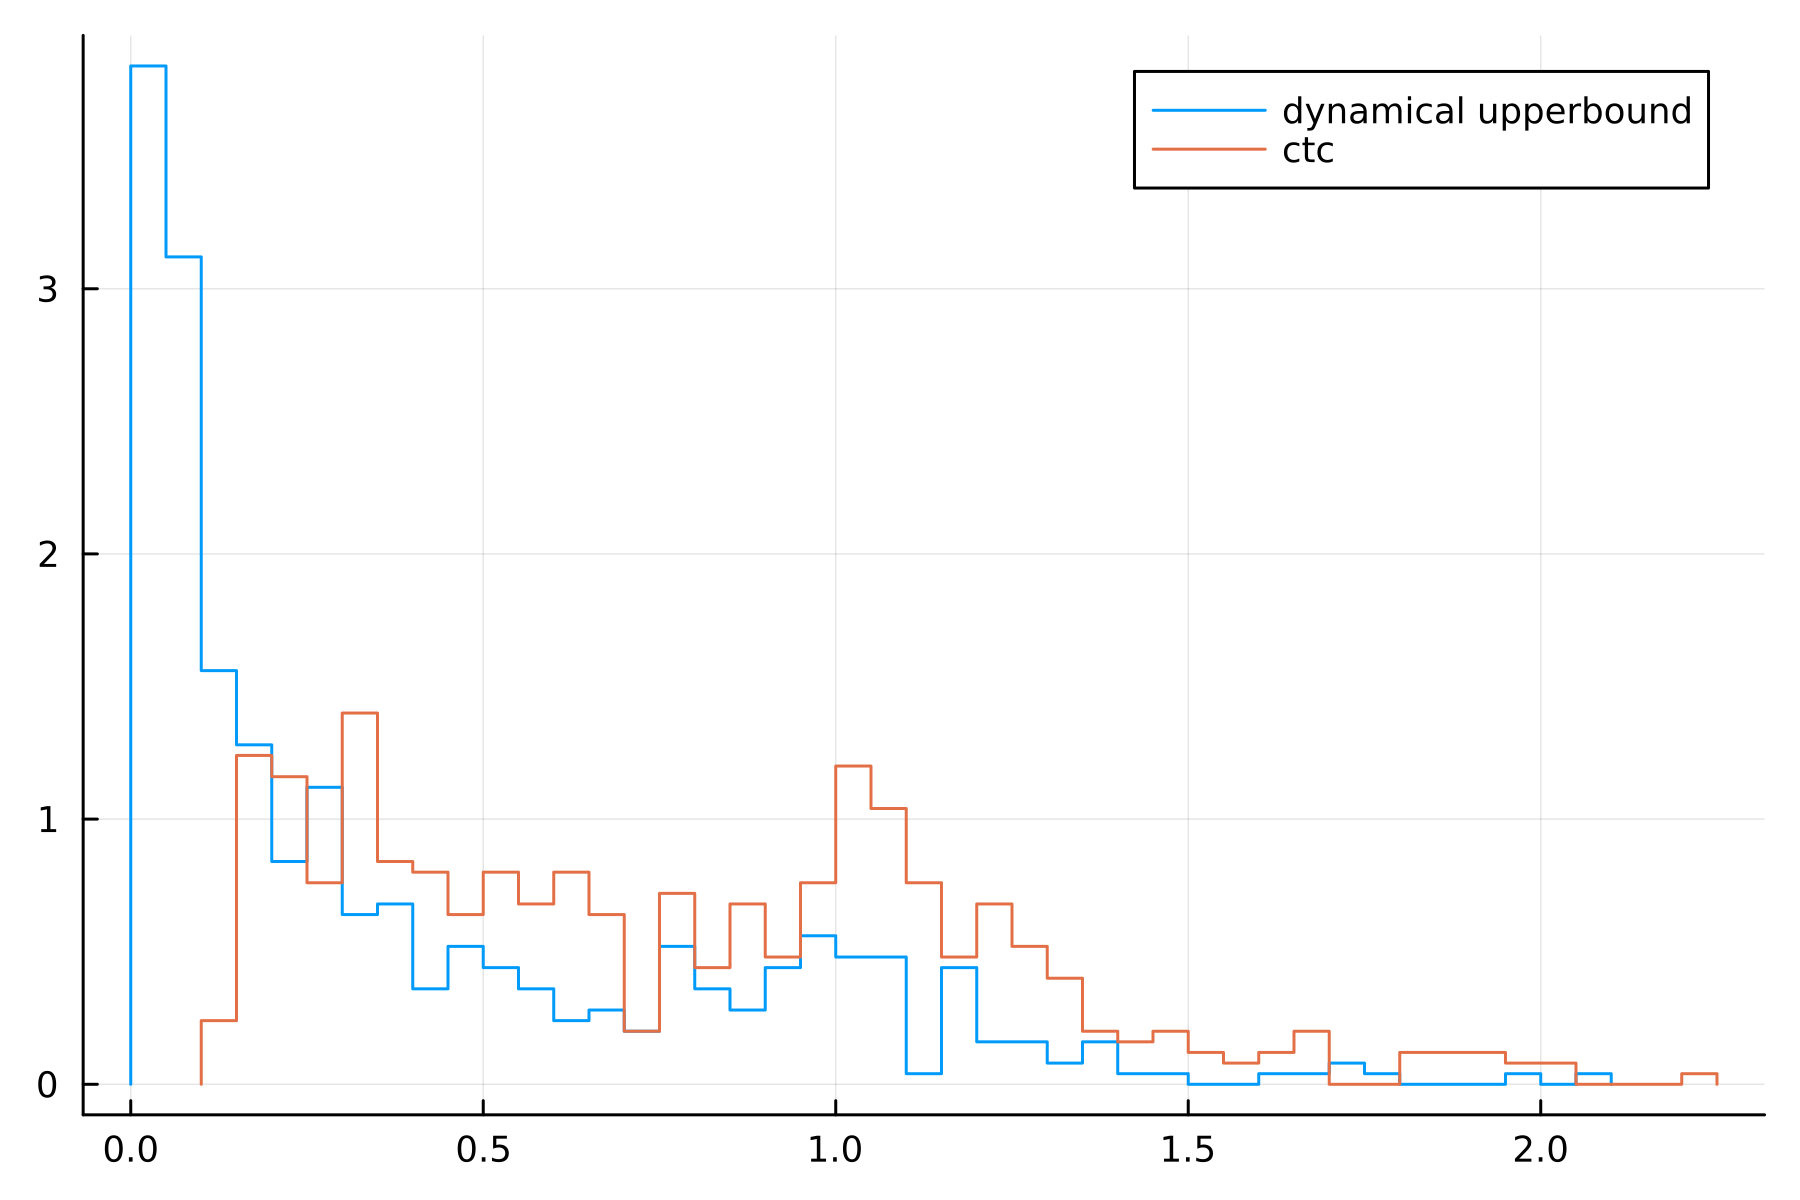

In [662]:
stephist(dynamical_upper_bound_all_2, label="dynamical upperbound", norm=true, dpi=300, bins=50)
stephist!(2 * ctc, label="ctc", norm=true,bins=50)
#savefig("step histogram CTC and dynamical upper bound,etc W=10, J=0.1, L=10.png")

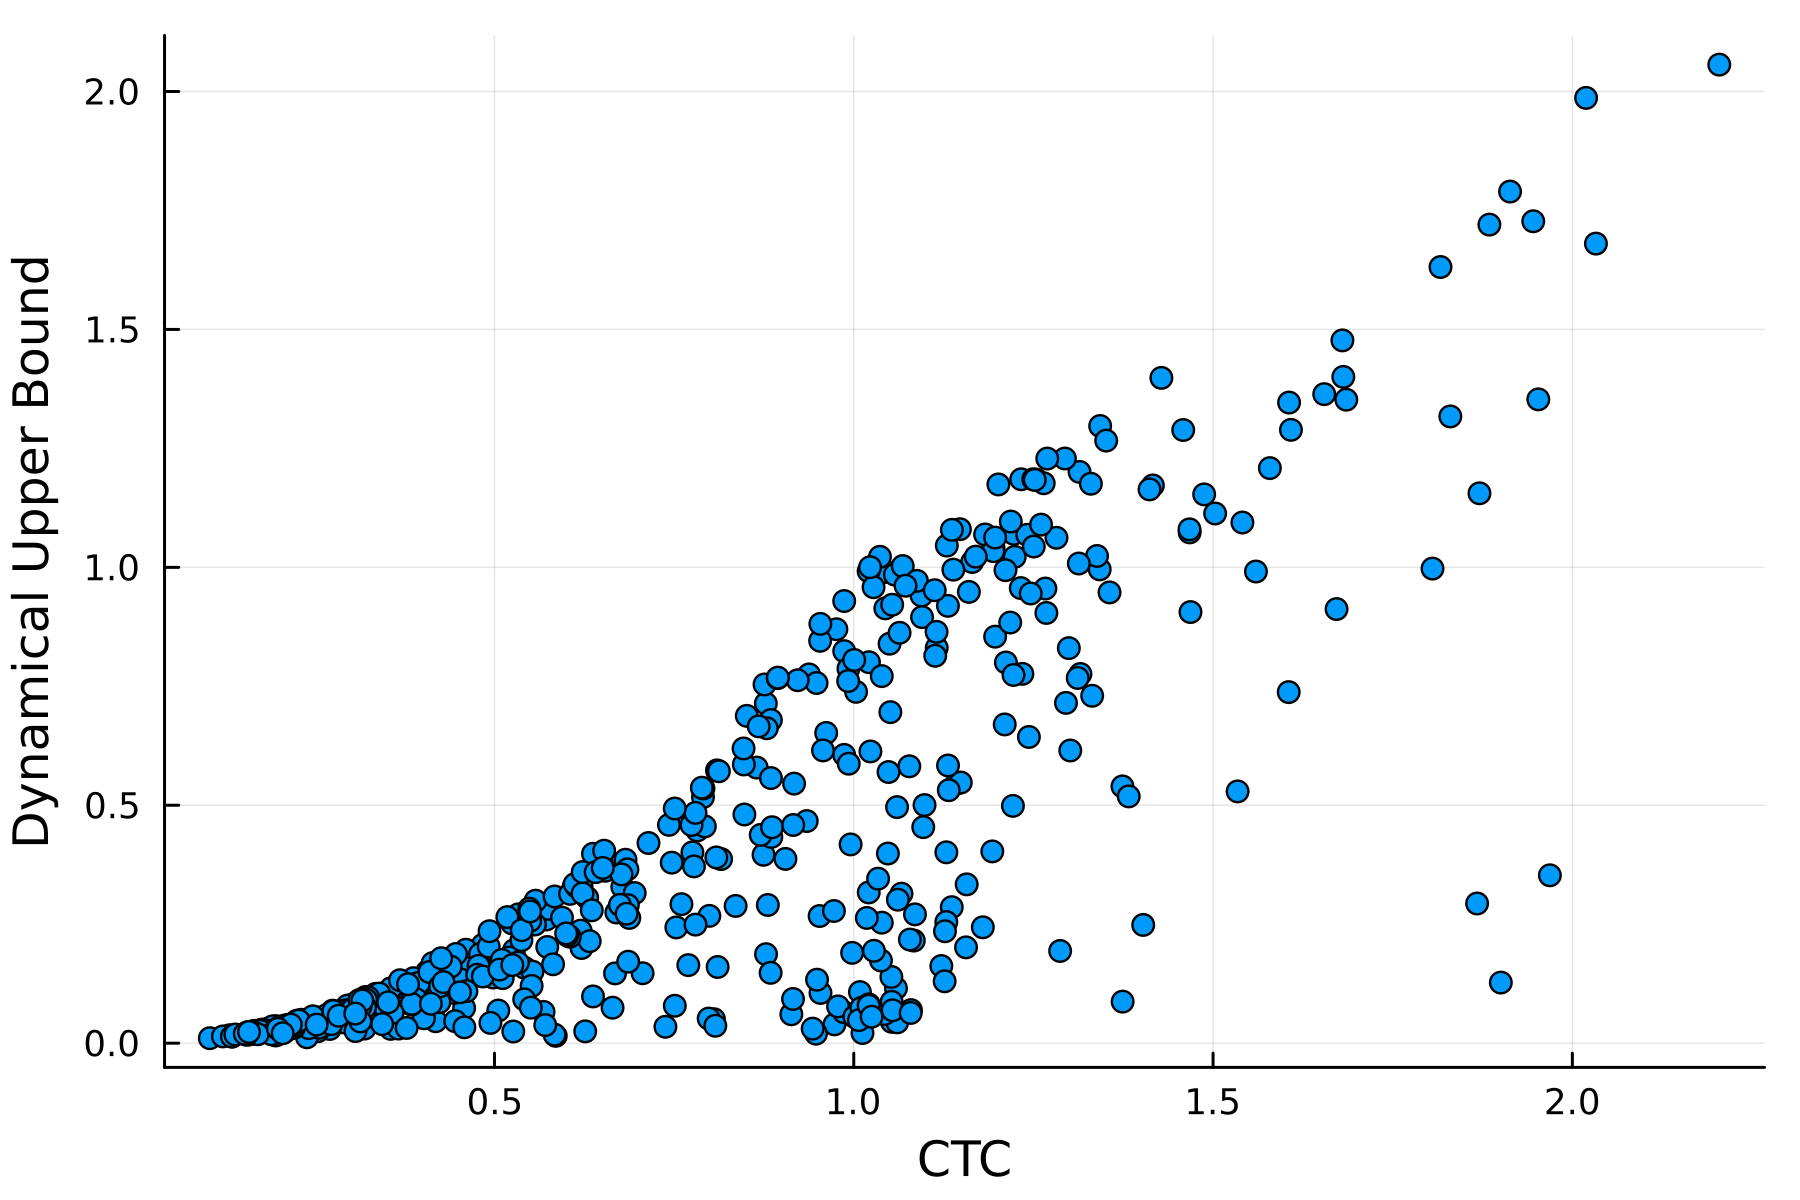

In [663]:
scatter(2* ctc,dynamical_upper_bound_all_2, xlabel="CTC", ylabel="Dynamical Upper Bound", label=false, dpi=300)
#savefig("CTC vs dynamical upper bound W=1, J=1, L=10.png")

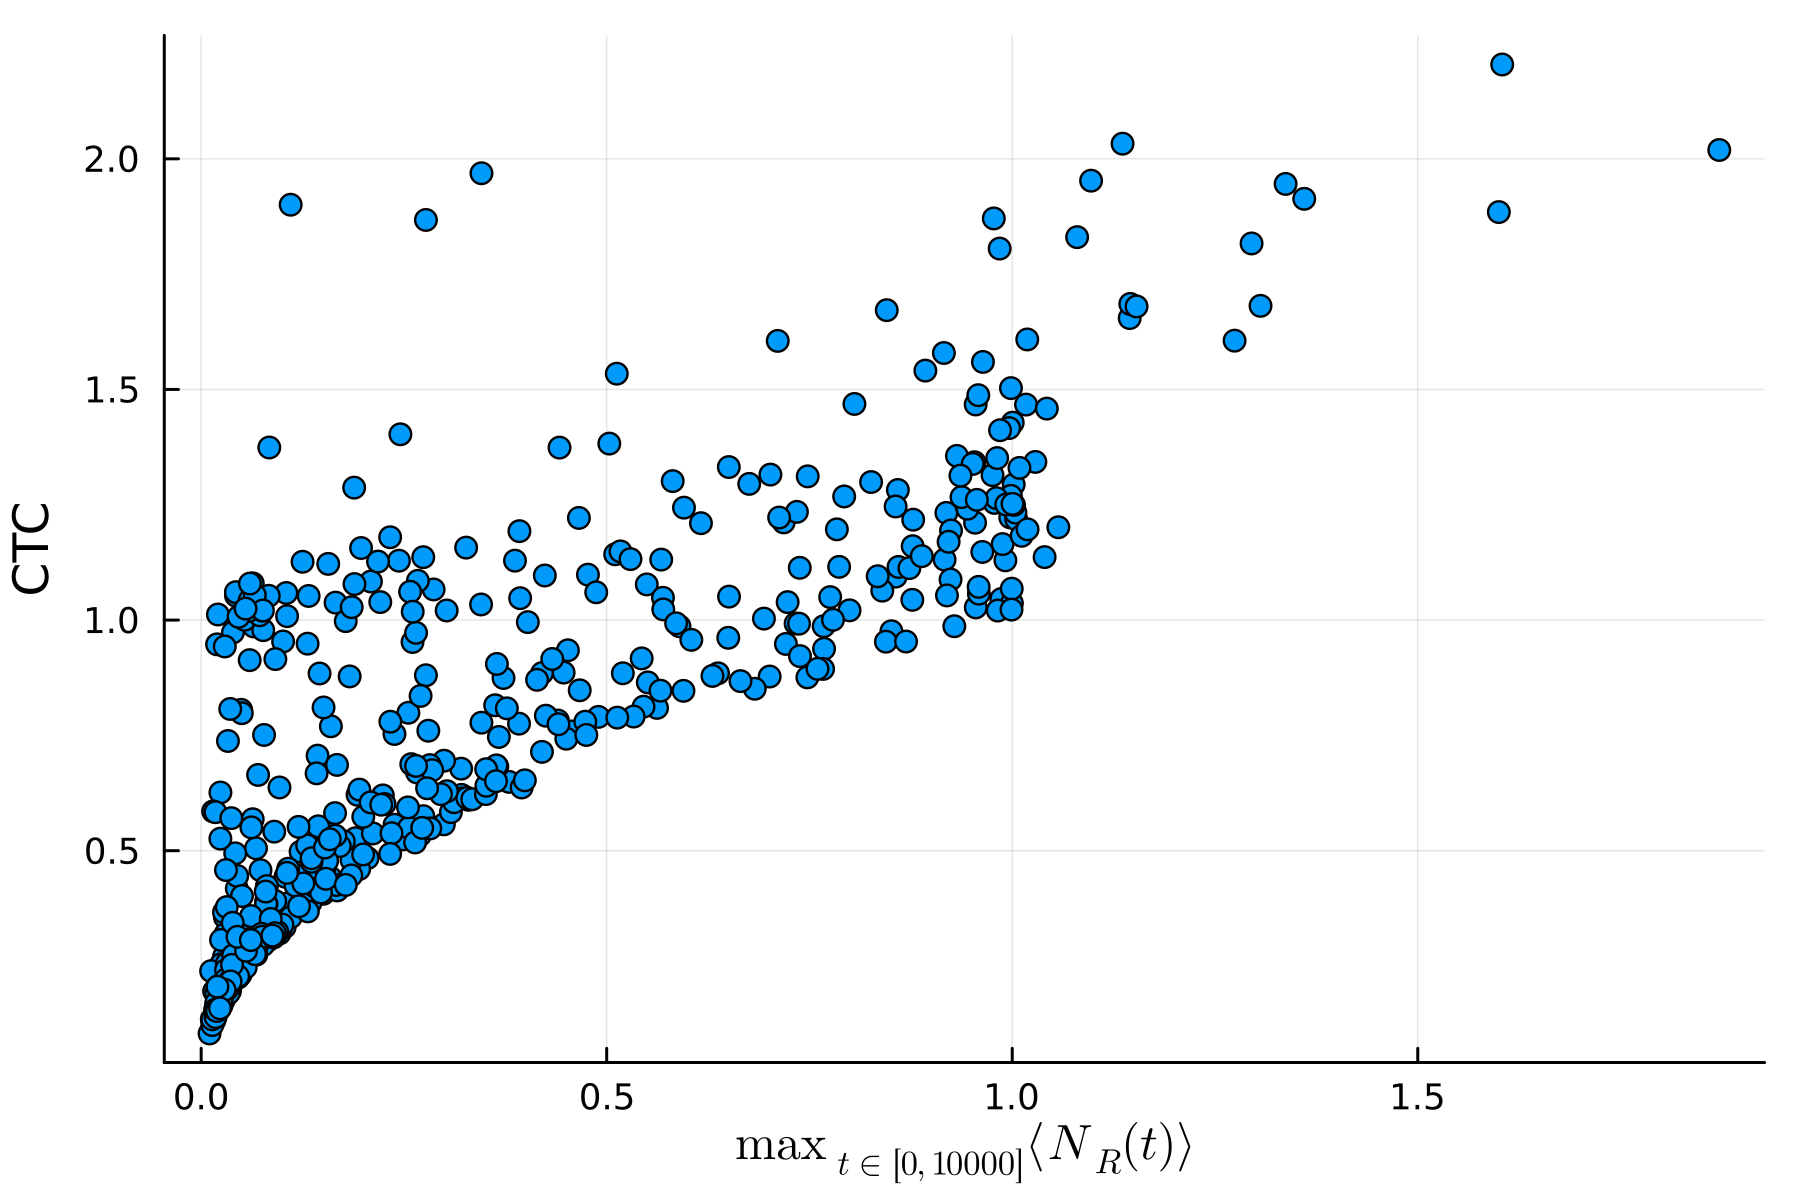

In [664]:
scatter(maximum_particles_transported, 2*ctc, label=false, dpi=300, xlabel=L"\max_{t\in[0,10000]}{\langle N_R(t)\rangle}", ylabel="CTC")
#savefig("CTC vs max particles transported W=1, J=1, L=10.png")

In [666]:
scatter(maximum_particles_transported, dynamical_upper_bound_all_2, label=false, dpi=300, xlabel=L"\max_{t\in[0,10000]}{\langle N_R(t)\rangle}", ylabel="DCTC")
savefig("DCTC vs max particles transported W=10, J=0.1, L=10.png")

"/Users/jessica/git/Square-Spin-Ice/New code/DCTC vs max particles transported W=10, J=0.1, L=10.png"

In [460]:
dynamical_upper_bound_all_2

1-element Vector{Any}:
 7.2241377099582555

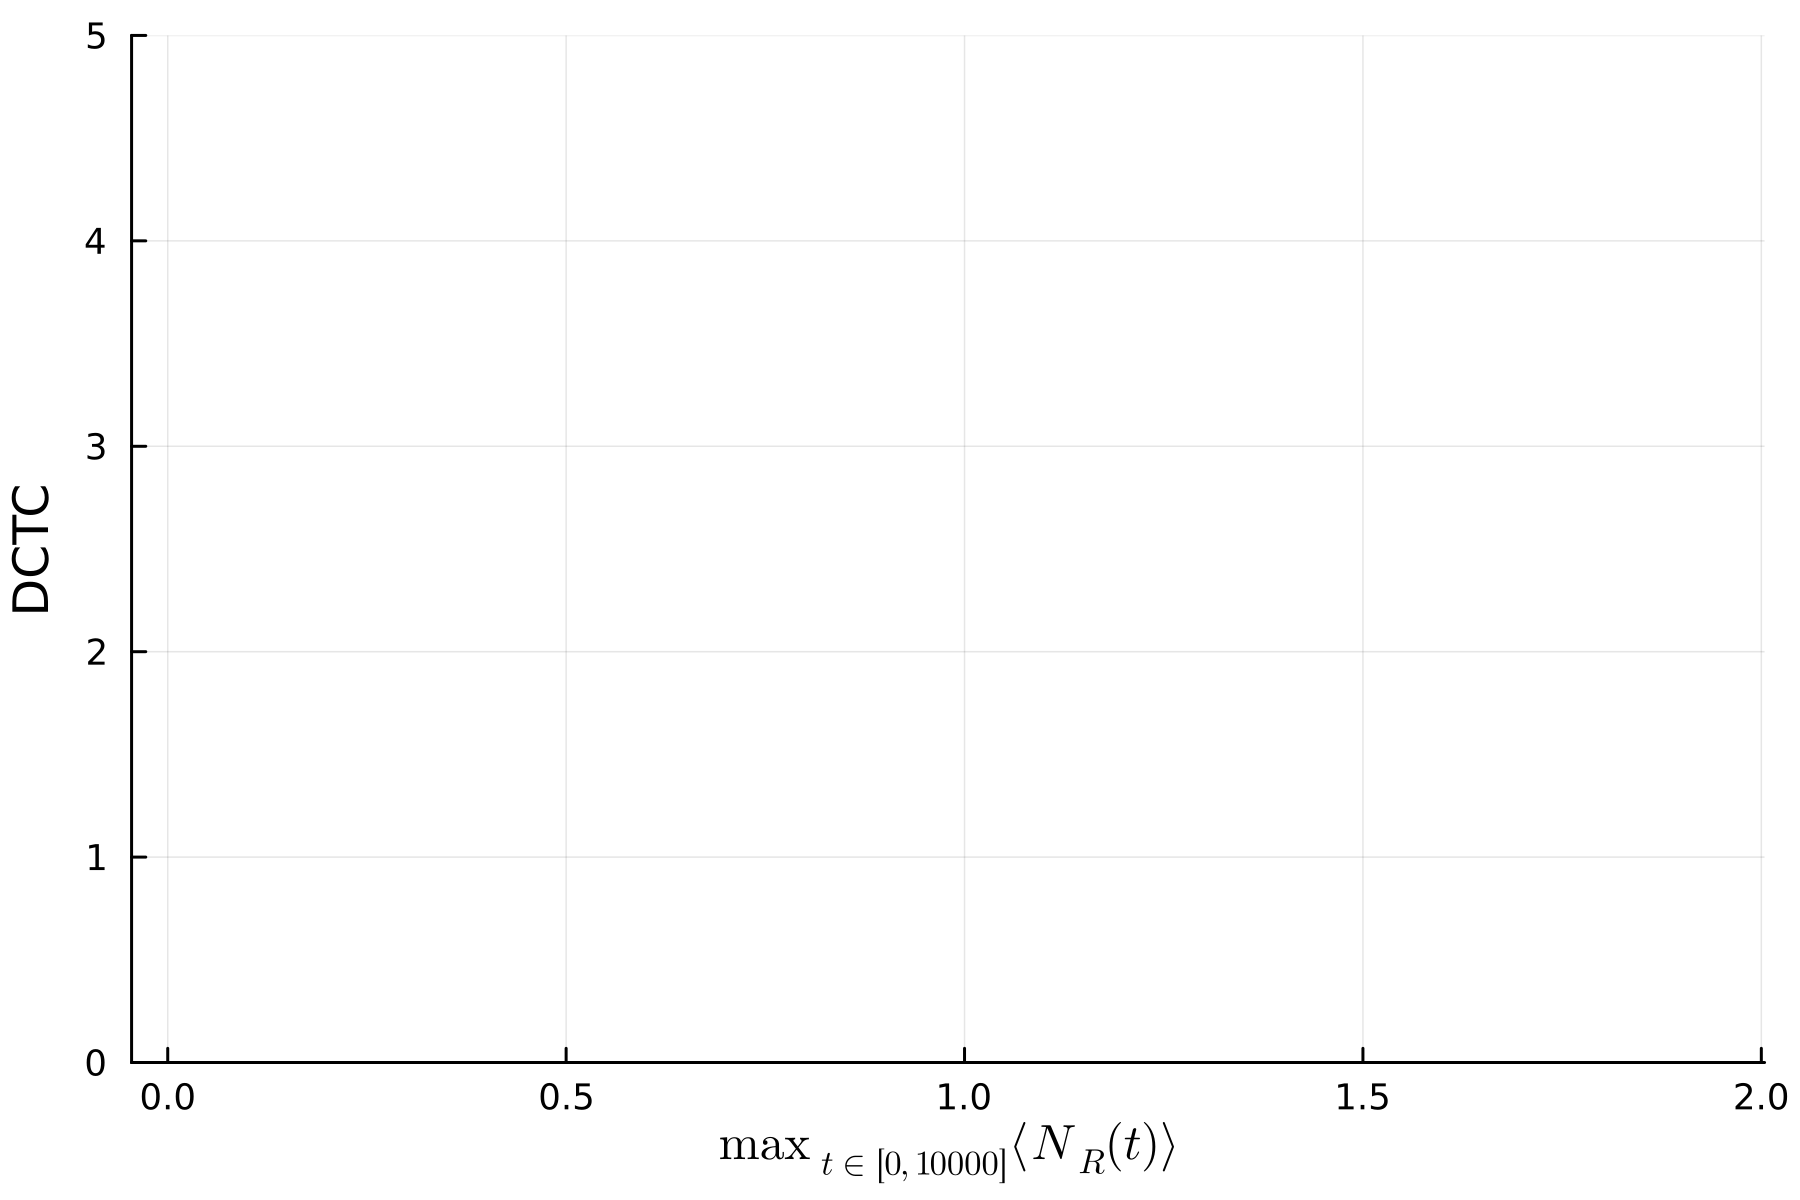

In [456]:
scatter(maximum_particles_transported, dynamical_upper_bound_all_2, label=false, dpi=300, xlabel=L"\max_{t\in[0,10000]}{\langle N_R(t)\rangle}", ylabel="DCTC", yrange=(0,5))


In [455]:
maximum_particles_transported, dynamical_upper_bound_all_2

(Any[0.8387054685796402, 0.0469054959335531, 0.01551621875802124, 0.1531942433369168, 0.9990846106689195, 0.7300419184004043, 0.8686352882342351, 0.18010222626521544, 1.4518841040518644, 0.8271535926735465  …  0.8113840163031817, 0.11016970421044847, 1.0711570645408952, 0.1376239239770035, 0.8737371099661587, 0.8928850344372966, 0.15451826130884955, 0.10155108067731956, 0.03123445553769317, 0.9290745266888164], Any[7.2241377099582555])

# Testing purposes

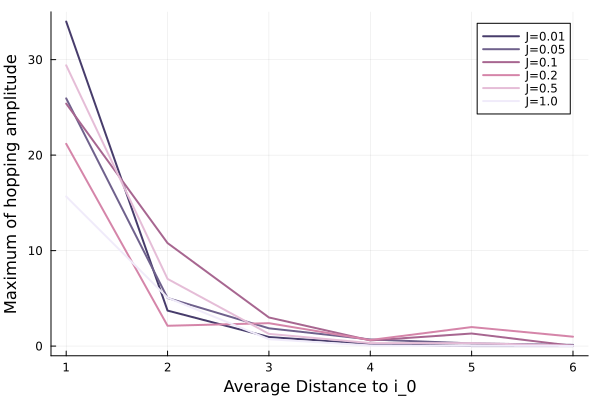

"/Users/jessica/git/Square-Spin-Ice/New code/hopping_amplitude_vs_distance_i_0.png"

In [2]:
include("unitTests.jl")
# 500 disorder realizations
J_mags=[0.01, 0.05, 0.1, 0.2,0.5, 1]

gradient = cgrad(:acton, length(J_mags))  # Use a perceptually uniform colormap


p=plot(linewidth=2, xlabel="Average Distance to i_0", ylabel="Maximum of hopping amplitude")

count=1
for J_mag in J_mags
    iterations=500
    L= 12; # system size
    T = 1 # random hopping strength
    t = T*ones(Float64, L); #hopping
    #t = ones(L)
    W = 10; # disorder strength
    the_map=construct_map_of_n_filling_states(L, div(L,2))
    d=Uniform(-1,1)
    i_0=div(L,2)
    J = J_mag*ones(Float64, L); # interactions
    all_data=[]
    max_time=10

    h=W*rand(d, L)
    H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
    eigtemp=eigen(H_half_filling);
    N_L=get_N_L_operator(L,the_map, i_0)
    N_L=eigtemp.vectors'*N_L*eigtemp.vectors
    particle_number=[]
    the_states=prepare_half_filling_state(eigtemp.vectors, the_map, L, i_0)
    
        time_evolved=time_evolve_state(the_states, eigtemp.values, max_time)
        number_particles_left=measure_number_particles_left_of_i_0(time_evolved, the_map,eigtemp.vectors, L, i_0).re
        number_particles_right=measure_number_particles_right_of_i_0(time_evolved, the_map,eigtemp.vectors, L, i_0).re

means=[]
    N_R_no_diag_computational_basis=eigtemp.vectors * get_N_R_operator_eigenstate_basis(L, the_map, eigtemp.vectors, i_0) * eigtemp.vectors'
    the_list=find_hopping_norms_sorted_by_distance_average_from_i0_sector(N_R_no_diag_computational_basis, L, L, div(L,2), the_map, false)
    for i in the_list
        push!(means,maximum(i))
    end
        index = trunc(Int, (count / length(J_mags)) * length(gradient))
plot!(p, 1:div(L,2), means, label="J="*string(J_mag), color=gradient[index],linewidth=2)
    count+=1
end


display(p)
savefig(p, "hopping_amplitude_vs_distance_i_0.png")

In [171]:
include("unitTests.jl")
iterations=1
    L= 5; # system size
    T = 1 # random hopping strength
    t = T*ones(Float64, L); #hopping
    #t = ones(L)
    W = 10; # disorder strength
    the_map=construct_map_of_n_filling_states(L, div(L,2))
    d=Uniform(-1,1)
    i_0=div(L,2)
J_mag=0.1
    J = J_mag*ones(Float64, L); # interactions
    all_data=[]
    max_time=10

    h=W*rand(d, L)

H, max_index_half=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, true, "full")
print(h)

[6.584814815302098, 3.186789206873506, -1.2068843227373804, 2.0510773472415345, -5.6137153511181985]

In [170]:
h

4-element Vector{Float64}:
  9.048464868226379
  6.901671199980218
 -1.553885141545981
 -3.740901090619957

In [169]:
H[6,6]

7.694579726680397

In [155]:
function each_configs_with_ones(L::Int, ones::AbstractVector{Int})
    base = zero(UInt)
    @inbounds for i in ones
        base |= UInt(1) << (i-1)
    end
    free = setdiff(1:L, ones)
    n = length(free)
    return collect(begin
        x = base
        @inbounds for k in 1:n
            if (m >> (k-1)) & 0x1 == 1
                x |= UInt(1) << (free[k]-1)
            end
        end
        Int(x)
    end for m in UInt(0):(UInt(1)<<n)-UInt(1))
end

each_configs_with_ones (generic function with 1 method)

In [151]:
function get_interaction_term(sites, H)
    possible_sites=collect(combinations(sites))
    push!(possible_sites,[])
    sum=0
    println(possible_sites)
    for s in possible_sites
        state=0
        for i in s
            state = flipBit(i-1,state)
        end
        sum+=H[state+1, state+1]*(-1)^(length(sites)-length(s))
        #println(H[state+1, state+1]*(-1)^(length(sites)-length(s)))
    end
    return sum
end

get_interaction_term (generic function with 2 methods)

In [145]:
J

4-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1

In [6]:
include("unitTests.jl")
# 500 disorder realizations
J_mags=[0.05, 0.1, 0.5, 1]

gradient = cgrad(:acton, length(J_mags))  # Use a perceptually uniform colormap
W = 10; # disorder strength
T = 1 # random hopping strength


p=plot(linewidth=2, xlabel="Average Distance to i_0", ylabel="Maximum of hopping amplitude")
all_all_data=[]
count=1
L= 12; # system size
for J_mag in J_mags
    all_data=[Float64[] for i=0:div(L,2)]
    println("J")
    println(J_mag)
    for i=1:500
        L= 12; # system size
        t = T*ones(Float64, L); #hopping
        #t = ones(L)
        the_map=construct_map_of_n_filling_states(L, div(L,2))
        d=Uniform(-1,1)
        i_0=div(L,2)
        J = J_mag*ones(Float64, L); # interactions
    
        h=W*rand(d, L)
        H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor(L, J, h, t, false, "full")
        eigtemp=eigen(H_half_filling);
        N_L=get_N_L_operator(L, i_0)
        N_L=eigtemp.vectors'*N_L*eigtemp.vectors
    
        N_R_no_diag_computational_basis=eigtemp.vectors * get_N_R_operator_eigenstate_basis(L, eigtemp.vectors, i_0) * eigtemp.vectors'
        the_list=find_all_terms_sorted_by_distance_average_from_i_0(N_R_no_diag_computational_basis, L, L, div(L,2), false)
        count1=1
        for i in the_list
            push!(all_data[count1],maximum(i))
            count1+=1
        end
    end
    push!(all_all_data, all_data)

    means=[mean(a) for a in all_data]
    
        index = trunc(Int, (count / length(J_mags)) * length(gradient))
    plot!(p, 0:div(L,2), means, label="J="*string(J_mag), color=gradient[index],linewidth=2)
    count+=1
end
save_object("L=12_operator_support="*string(W)*", J="*string(J_mag)*", t="*string(T)*".jld2", all_all_data)
display(p)
savefig(p, "support_amplitude_vs_distance_i_0_larger_L.png")


J
0.05
J
0.1
J
0.5
J
1.0


LoadError: UndefVarError: `J_mag` not defined

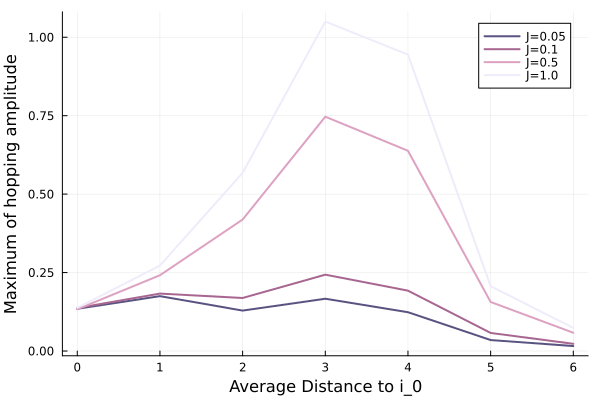

In [7]:
display(p)


In [192]:
plot!(p, dpi=300)
savefig("support_amplitude_vs_distance_i_0.png")

"/Users/jessica/git/Square-Spin-Ice/New code/support_amplitude_vs_distance_i_0.png"

In [210]:
means

6-element Vector{Any}:
 0.09313487267856474
 0.1324231015661931
 0.17285605384228028
 0.0549192293041899
 0.1326836658238877
 0.0824761179517085

In [203]:
N_R_no_diag_computational_basis=eigtemp.vectors * get_N_R_operator_eigenstate_basis(L, the_map, eigtemp.vectors, i_0) * eigtemp.vectors'

924×924 Matrix{Float64}:
  0.0101645     0.056712     -0.00175094   …  -8.36033e-18   7.41491e-19
  0.056712     -0.00503285   -0.000590093      1.10763e-16   6.7581e-20
 -0.00175094   -0.000590093   0.000391128     -5.53612e-16   7.25677e-17
  0.00114604   -0.000164456  -0.000115993     -6.18316e-15   4.11653e-16
  0.000412886  -3.32713e-5   -0.000151078     -1.88776e-14   1.42482e-15
 -0.000222838  -5.51069e-6    0.000105101  …  -7.73603e-14   5.92624e-15
  0.000117874   1.30666e-5   -9.80738e-5      -3.84265e-14   1.99194e-15
 -0.00600371   -0.00675775   -0.00179829      -5.24894e-18   4.01845e-17
 -0.0353689    -0.000510397   0.000146155     -8.77489e-15   1.05694e-15
 -0.00985969    0.000121283   8.75618e-5      -7.30199e-14   5.24976e-15
 -0.00605776    0.000181006  -4.82996e-5   …  -1.60797e-13   1.56703e-14
  0.0030458    -0.000206203  -2.36172e-5      -7.13974e-13   6.7213e-14
 -0.00159687   -7.47102e-6   -1.15693e-5      -1.50958e-13   6.43497e-15
  ⋮                         

In [204]:
the_list=find_hopping_norms_sorted_by_distance_maximum_from_i0_sector(N_R_no_diag_computational_basis, L, L, div(L,2), the_map, false)

6-element Vector{Vector{Any}}:
 [0.09313487267856474, 0.012295319187712964, 0.06499519817813508]
 [0.1324231015661931, 0.03100005393334688, 0.0025302309767783675, 0.01772468886481861, 0.03956204110464543, 0.04386404393168609, 0.02764258499065412, 0.0003219793952537553, 0.002910321386802086, 0.0020914841006431134  …  0.008091142790000554, 0.0002808764526088915, 0.009089866515586435, 0.009173661335298986, 0.0008544778929049118, 0.002309154224263255, 0.002312411887054136, 0.0015896238502540632, 0.006629537335620288, 0.006786661079539914]
 [0.05674179530069815, 0.12656840808266823, 0.03753763696032828, 0.0032670050246448477, 0.04436906067872535, 0.08431585249299603, 0.033387053989953, 0.04107011825554393, 0.014609277969039412, 0.014603796890161096  …  0.00032823521459328446, 0.0006580639595232092, 0.000674034988242616, 5.054087030844838e-5, 0.00135680104534506, 0.00131038001684622, 0.000811085561526109, 0.0008187532047439423, 0.0009029299189016488, 0.0007498195435338417]
 [0.04093014058037

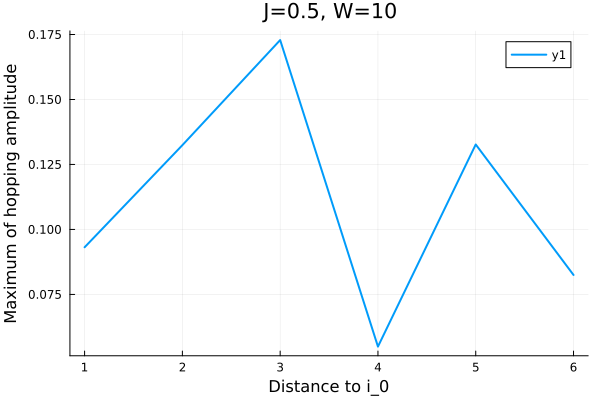

"/Users/jessica/git/Square-Spin-Ice/New code/hopping_amplitude_vs_distance_i_0_W=10,J=0.5.png"

In [205]:
means=[]
for i in the_list
    push!(means,maximum(i))
end
p=plot(1:div(L,2), means, linewidth=2, xlabel="Distance to i_0", ylabel="Maximum of hopping amplitude", title="J="*string(J_mag)*", W="*string(W))

display(p)
savefig(p, "hopping_amplitude_vs_distance_i_0_W="*string(W)*",J="*string(J_mag)*".png")

In [20]:
include("unitTests.jl")
average_hopping_distance_from_i_0_obc(([1,2,100],[5,6,7]), 4)


17.833333333333332

In [68]:
find_possible_pivots_sector([1], [2], the_map)

252-element Vector{Any}:
 (2262, 2263)
 (1954, 1955)
 (2842, 2843)
 (3474, 3475)
 (366, 367)
 (2502, 2503)
 (1086, 1087)
 (2142, 2143)
 (686, 687)
 (1626, 1627)
 (1746, 1747)
 (1118, 1119)
 (486, 487)
 ⋮
 (2914, 2915)
 (2606, 2607)
 (870, 871)
 (462, 463)
 (1818, 1819)
 (1182, 1183)
 (3282, 3283)
 (606, 607)
 (3274, 3275)
 (222, 223)
 (3858, 3859)
 (3226, 3227)

In [307]:
the_states' * get_N_R_operator_eigenstate_basis(L, the_map, eigtemp.vectors, i_0) * the_states

1.143862027726409

In [308]:
the_states' * eigtemp.vectors' * get_N_R_operator(L, the_map, i_0) * eigtemp.vectors * the_states

5.999999999999974

In [235]:
T = 1 # random hopping strength
L=6
W=0
JJ=1
t = T*ones(Float64, L); #hopping
#t = ones(L)
d=Uniform(-1,1)
h = W*rand(d, L); # disordered onsite potentials
J = JJ*ones(Float64, L); # interactions
H,max_index=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, true,"full")

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 4.0 0.0; 0.0 0.0 … 0.0 6.0], Vector{Any}[[(2, 3), (6, 7), (10, 11), (14, 15), (18, 19), (22, 23), (26, 27), (30, 31), (34, 35), (38, 39), (42, 43), (46, 47), (50, 51), (54, 55), (58, 59), (62, 63)], [(3, 5), (4, 6), (11, 13), (12, 14), (19, 21), (20, 22), (27, 29), (28, 30), (35, 37), (36, 38), (43, 45), (44, 46), (51, 53), (52, 54), (59, 61), (60, 62)], [(5, 9), (6, 10), (7, 11), (8, 12), (21, 25), (22, 26), (23, 27), (24, 28), (37, 41), (38, 42), (39, 43), (40, 44), (53, 57), (54, 58), (55, 59), (56, 60)], [(9, 17), (10, 18), (11, 19), (12, 20), (13, 21), (14, 22), (15, 23), (16, 24), (41, 49), (42, 50), (43, 51), (44, 52), (45, 53), (46, 54), (47, 55), (48, 56)], [(17, 33), (18, 34), (19, 35), (20, 36), (21, 37), (22, 38), (23, 39), (24, 40), (25, 41), (26, 42), (27, 43), (28, 44), (29, 45), (30, 46), (31, 47), (32, 48)], [(2, 33), (4, 35), (6, 37), (8, 39), (10, 41), (12, 43), (14, 45), (16, 47), (18, 49), (20, 51), (22, 53), (2

In [145]:
T = 1 # random hopping strength
L=4
JJ=1
t = T*ones(Float64, L); #hopping
#t = ones(L)
d=Uniform(-1,1)
h = W*rand(d, L); # disordered onsite potentials
J = JJ*ones(Float64, L); # interactions
#H,max_index=construct_disordered_interacting_hamiltonian_nearest_neighbor(L, J, h, t, false, "full")
H,max_index=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, true, "full")

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0 … 0.0 4.0], Vector{Any}[[(2, 3), (5, 8), (10, 11), (13, 16)], [(3, 5), (4, 6), (9, 15), (10, 16)], [(2, 14), (4, 16), (5, 9), (7, 11)], [(3, 12), (4, 11), (7, 16), (8, 15)]])

In [168]:
H[6,6]

2.0

In [204]:
L= 5; # system size
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 3.1; # disorder strength

d=Uniform(-1,1)
h=W*rand(d, L)
J_mag=0
J = J_mag*ones(Float64, L); # interactions
H, max_index=construct_disordered_interacting_hamiltonian_next_nearest_neighbor(L, J, h, t, false, "full");
max_index = max_index[sortperm(t, rev=true)];

eigtemp=eigen(H)
eigenvectors=eigtemp.vectors

N_R_nodiag=get_N_R_operator_eigenstate_basis(L, eigenvectors, div(L, 2))
println(sqrt(maximum(abs,eigen(N_R_nodiag'*N_R_nodiag).values)))
println(sqrt(norm(N_R_nodiag)^2/(2^L)))

1.0524745977440797
0.4961680102804943


In [205]:
the_map=construct_map_of_n_filling_states(L, div(L,2))
H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
eigtemp=eigen(H_half_filling)

eigtemp=eigen(H_half_filling)
eigenvectors=eigtemp.vectors
println(size(eigenvectors))
N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))
println(sqrt(maximum(abs,eigen(N_R_nodiag'*N_R_nodiag).values)))
println(sqrt(norm(N_R_nodiag)^2/(binomial(L, div(L,2)))))

(10, 10)
1.0524745977440086
0.543524823086167


In [229]:
t = T .* (1 .+ (0:L-1) .% 2)

5-element Vector{Int64}:
 1
 2
 1
 2
 1

In [164]:
construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling

LoadError: UndefVarError: `construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling` not defined

# Run this!

In [3]:
Ls=[4,6,8,10,12,14]
Ws=collect(range(start=2, stop=8, step=1))
Js=collect(range(start=0, stop=0, step=1))
disorder_realizations=1
T =1 # random hopping strength
JJ=0
norms=[]
norms_frobenius=[]
dynamical_upper_bound_all_3=[]

phase=0
alpj=0.5
phases=range(0, stop=1/sqrt(2), length=500)

the_norms=[]
W=0
for JJ in Js
    println("W="*string(W))
    norms_W=[]
    
    norms_frobenius_W=[]
        DCTC_W=[]

for L in Ls
    println("L="*string(L))
    disorder_realizations_data_L=[]
    disorder_realizations_data_L_f=[]
    dynamical_upper_bound_all_2=[]
    the_map=construct_map_of_n_filling_states(L, div(L,2))

    for i=1:phases
        t = T*ones(Float64, L); #hopping

        i_0=div(L,2)

        #t = ones(L)
        d=Uniform(-1,1)
        h = W*rand(d, L); # disordered onsite potentials
            h=2*v*cos.(2*pi*sqrt(2).*(xrange.+i)) ./ (1 .- alpj .* cos.(2*pi*sqrt(2).*(xrange.+phase)))

        J = JJ*ones(Float64, L); # interactions
        H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")        
        eigenvalues, eigenvectors=eigen(H_half_filling);
        N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))

        the_states=prepare_half_filling_state(eigenvectors, the_map, L, i_0)

        N_R=get_N_L_operator(L,the_map, i_0)
        N_R=eigenvectors'*N_R*eigenvectors
        N_R_nodiag=N_R-Diagonal(diag(N_R))


        N_L=get_N_R_operator(L,the_map, i_0)
        N_L=eigenvectors'*N_L*eigenvectors

            
        values, vecs, info=eigsolve(N_R_nodiag, 1, :SR; ishermitian=true);
        values_2, vecs, info=eigsolve(N_R_nodiag, 1, :LR; ishermitian=true);
        
        push!(disorder_realizations_data_L,(values_2[1]-values[1])/2)
        push!(disorder_realizations_data_L_f,norm(N_R_nodiag))

            # dynamical upper bound

    v = abs.(the_states)           # |ψ|
    A = abs.(N_R)                  # |N|
    tmp = similar(v)               # workspace
    mul!(tmp, A, v)                # tmp = A * v  (fast, BLAS / sparse matvec)
    dynamical_upper_bound = dot(v, tmp)
    push!(dynamical_upper_bound_all_2, dynamical_upper_bound)
            
    end
    push!(norms_W,disorder_realizations_data_L)
    push!(norms_frobenius_W,disorder_realizations_data_L_f)
    push!(DCTC_W,dynamical_upper_bound_all_2)

end
    save_object("9_4_M_operator_norm_W="*string(W)*", J="*string(JJ)*", t="*string(T)*".jld2", norms_W)
    save_object("9_4_M_frobenius_norm_W="*string(W)*", J="*string(JJ)*", t="*string(T)*".jld2", norms_frobenius_W)
    save_object("9_4_M_dctc_norm_W="*string(W)*", J="*string(JJ)*", t="*string(T)*".jld2", DCTC_W)


    push!(norms, norms_W)
    push!(norms_frobenius, norms_frobenius_W)
    push!(dynamical_upper_bound_all_3, DCTC_W)

end

W=0
L=4


LoadError: MethodError: no method matching (::Colon)(::Int64, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})

[0mClosest candidates are:
[0m  (::Colon)(::T, ::Any, [91m::T[39m) where T<:Real
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:50[24m[39m
[0m  (::Colon)(::A, ::Any, [91m::C[39m) where {A<:Real, C<:Real}
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:10[24m[39m
[0m  (::Colon)(::T, ::Any, [91m::T[39m) where T
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:49[24m[39m
[0m  ...


In [611]:
L=12
T=1
t = T*ones(Float64, L); #hopping
i_0=div(L,2)
W=0
JJ=0
#t = ones(L)
d=Uniform(-1,1)
h = W*rand(d, L); # disordered onsite potentials
J = JJ*ones(Float64, L); # interactions
the_map=construct_map_of_n_filling_states(L, div(L,2))
H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_next_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")        
eigenvalues, eigenvectors=eigen(H_half_filling);
N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))

the_states=prepare_half_filling_state(eigenvectors, the_map, L, i_0)

N_R=get_N_L_operator(L,the_map, i_0)
N_R=eigenvectors'*N_R*eigenvectors
N_R_nodiag=N_R-Diagonal(diag(N_R))


N_L=get_N_R_operator(L,the_map, i_0)
N_L=eigenvectors'*N_L*eigenvectors

    
values, vecs, info=eigsolve(N_R_nodiag, 1, :SR; ishermitian=true);
values_2, vecs, info=eigsolve(N_R_nodiag, 1, :LR; ishermitian=true);

println("hello")
println(the_states' * N_L * the_states)

states=zeros(Float64, length(collect(Base.keys(the_map))))

#=
for i=1:div(L,2)-1
    states[i]=1
end
states[div(L,2)+1] = 1

states=states ./ sqrt(div(L,2))
=#

states[1]=1
the_states= eigenvectors'*states

#println(the_states)

println("hello")
println(the_states' * N_L * the_states)

#println(eigenvectors * the_states)

# dynamical upper bound

v = abs.(the_states)           # |ψ|
A = abs.(N_R)                  # |N|
tmp = similar(v)               # workspace
mul!(tmp, A, v)                # tmp = A * v  (fast, BLAS / sparse matvec)
dynamical_upper_bound = dot(v, tmp)
println(dynamical_upper_bound)            

hello
5.999999999999976
hello
5.999999999999985
6.162735700562157


In [619]:
the_states

924-element Vector{Float64}:
 -4.7544289316993677e-7
  3.468940610364937e-6
 -1.7560787543278747e-5
 -3.1944455958264964e-8
 -4.021701557425754e-5
  2.5228411041754856e-7
  5.869277883195634e-5
  6.411182703732442e-5
 -7.472579048920479e-7
  2.008408777047759e-6
  0.00021175183863164334
 -0.00010392546600453915
  7.117306356379562e-5
  ⋮
  0.0001039254660045192
  3.749018252527901e-6
 -0.00021172817415690288
 -1.922083597853154e-5
 -6.116734606592851e-5
  5.869277883201185e-5
  4.02131699022857e-5
  6.107007256657068e-7
 -4.3934951360932555e-7
 -1.7555319751953082e-5
  3.4689406103648066e-6
  4.754428931699398e-7

In [625]:
the_states[log.(abs.(the_states)).> -2]

8-element Vector{Float64}:
  0.15114934645896227
 -0.18476098548091457
 -0.15663389777695072
  0.20033114642397357
  0.15949299666893121
  0.15715619340445902
 -0.18452068013190084
 -0.15116015521662263

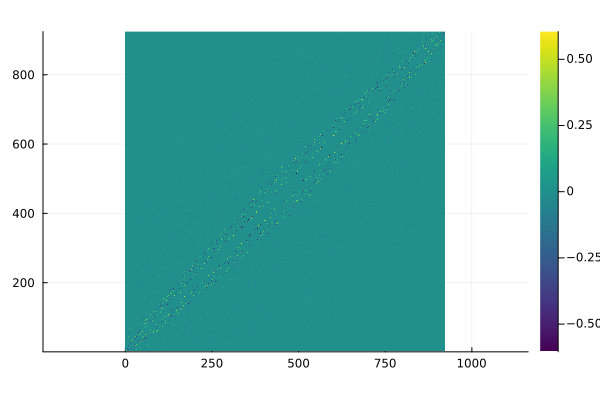

In [631]:
heatmap(N_L-Diagonal(diag(N_L)), color=:viridis, aspect_ratio=:equal)

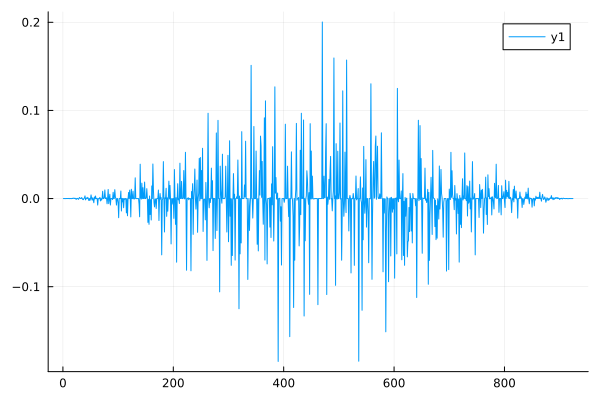

In [632]:
plot(the_states)

In [637]:
product_matrix=zeros(Float64, (length(the_states), length(the_states)))
for n=1:length(the_states)
    for m=1:length(the_states)
        product_matrix[n,m]=the_states[n]*the_states[m]
    end
end


In [638]:
product_matrix

924×924 Matrix{Float64}:
  2.26046e-13  -1.64928e-12   8.34915e-12  …  -1.64928e-12  -2.26046e-13
 -1.64928e-12   1.20335e-11  -6.09173e-11      1.20335e-11   1.64928e-12
  8.34915e-12  -6.09173e-11   3.08381e-10     -6.09173e-11  -8.34915e-12
  1.51878e-14  -1.10813e-13   5.6097e-13      -1.10813e-13  -1.51878e-14
  1.91209e-11  -1.3951e-10    7.06242e-10     -1.3951e-10   -1.91209e-11
 -1.19947e-13   8.75159e-13  -4.43031e-12  …   8.75159e-13   1.19947e-13
 -2.79051e-11   2.03602e-10  -1.03069e-9       2.03602e-10   2.79051e-11
 -3.04815e-11   2.224e-10    -1.12585e-9       2.224e-10     3.04815e-11
  3.55278e-13  -2.59219e-12   1.31224e-11     -2.59219e-12  -3.55278e-13
 -9.54884e-13   6.96705e-12  -3.52692e-11      6.96705e-12   9.54884e-13
 -1.00676e-10   7.34555e-10  -3.71853e-9   …   7.34555e-10   1.00676e-10
  4.94106e-11  -3.60511e-10   1.82501e-9      -3.60511e-10  -4.94106e-11
 -3.38387e-11   2.46895e-10  -1.24986e-9       2.46895e-10   3.38387e-11
  ⋮                       

In [641]:
sum(product_matrix)

0.9472487821196978

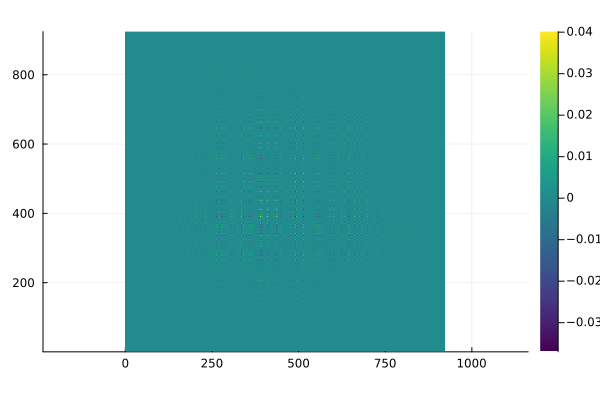

In [639]:
heatmap(product_matrix, color=:viridis, aspect_ratio=:equal)

In [581]:
the_map

Dict{Int64, Int64} with 6 entries:
  5  => 2
  6  => 3
  10 => 5
  9  => 4
  12 => 6
  3  => 1

In [573]:
the_states

LoadError: UndefVarError: `the_states` not defined

In [566]:
Ls

5-element Vector{Int64}:
  4
  6
  8
 10
 12

In [673]:
dynamical_upper_bound_all_3[3]

7-element Vector{Any}:
 Any[2.0]
 Any[3.0830463433337822]
 Any[4.328714661508117]
 Any[5.8320609532282095]
 Any[7.8977332317884805]
 Any[11.169607530808298]
 Any[17.67564697148438]

In [674]:
lolll=[]
for b in dynamical_upper_bound_all_3
lols=[median(a) for a in b]
    push!(lolll, lols)
end

In [675]:
lolll

11-element Vector{Any}:
 [1.9999999999999991, 3.02234504574988, 4.147387287961833, 5.108872697533307, 6.162735700562157, 11.215161296270193, 9.884756986373425]
 [2.0, 3.0544517036674015, 4.206391343218521, 5.575193266269714, 7.212170510729351, 9.332995409927054, 12.630165225947652]
 [2.0, 3.0830463433337822, 4.328714661508117, 5.8320609532282095, 7.8977332317884805, 11.169607530808298, 17.67564697148438]
 [1.9999999999999987, 3.0993635098272594, 4.40304294141264, 5.953334104077445, 8.319820748710445, 12.413005636742255, 22.10776171254231]
 [1.9999999999999996, 3.0945104641652366, 4.392704553115916, 6.031927918188762, 8.708030543038864, 14.07077093962161, 24.875917240194134]
 [2.0000000000000004, 3.1141721041602044, 4.413255569714354, 6.034832625320092, 8.944426284397167, 14.469380393718634, 25.799871998855565]
 [1.9999999999999998, 3.1179785065998367, 4.440493904184212, 6.0676563116987365, 8.978369662705981, 14.79454626643932, 25.54921272590668]
 [2.0, 3.1306284772413333, 4.45670324849

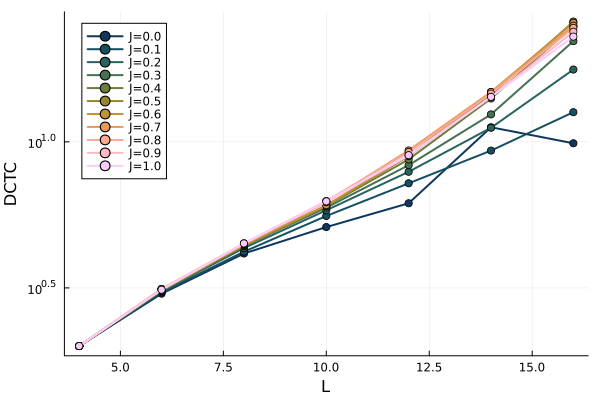

"/Users/jessica/git/Square-Spin-Ice/New code/DCTC_free_fermion_interactions.png"

In [684]:
gradient = cgrad(:batlow, length(lolll))  # Use a perceptually uniform colormap
p=plot(xlabel="L", ylabel="DCTC")
i=1
for a in lolll
    index=trunc(Int, (i / length(Js)) * length(gradient))
    plot!(p, Ls, a,marker=:circle,linewidth=2, label="J="*string(Js[i]), color=gradient[index], yaxis=:log)
    i+=1
end
display(p)
savefig("DCTC_free_fermion_interactions.png")

In [231]:
4 .* the_norms

6-element Vector{Float64}:
  4.000000000000002
  6.000000000000006
  8.000000000000002
 10.0
 12.000000000000005
 14.0000000000003

In [232]:
p=plot(Ls,the_norms, linewidth=2, markers=:circle, xticks=(Ls, Ls), ylabel=L"|\!|\hat M|\!|_{\mathrm{op}}",xlabel=L"L",label="",dpi=300)
savefig(p,"nonintegrable_alternating_hopping_free_M.png")

"/Users/jessica/git/Square-Spin-Ice/New code/nonintegrable_alternating_hopping_free_M.png"

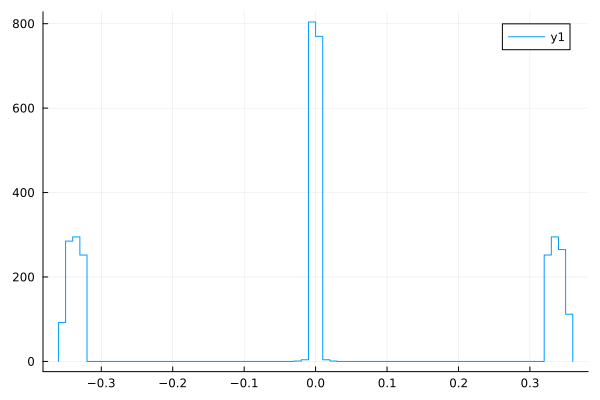

In [72]:
L=14
W=10
JJ=0.1
t = T*ones(Float64, L); #hopping
#t = ones(L)
d=Uniform(-1,1)
the_map=construct_map_of_n_filling_states(L, div(L,2))
h = W*rand(d, L); # disordered onsite potentials
J = JJ*ones(Float64, L); # interactions
H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")        
eigenvalues, eigenvectors=eigen(H_half_filling);
N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))
eigenvalues_2=eigen(N_R_nodiag).values
stephist(real.(eigenvalues_2),bins=100)

In [73]:
h

14-element Vector{Float64}:
 -2.167290462161786
 -6.614300453081148
 -5.110250394815985
 -4.561883042087507
  7.151542618323356
  9.742543809852442
  2.748524031068449
  0.3334296263426384
 -7.266616474933341
  7.892472439186431
 -3.5394744284195157
 -9.367657297334917
  8.762594298533205
 -5.362795838060999

In [69]:
real.(eigenvalues_2)

3432-element Vector{Float64}:
 -0.8244007760842472
 -0.7638600854679584
 -0.6512958654151181
 -0.3459704227777262
 -0.3353927763262531
 -0.3217618446507759
 -0.29871525016441086
 -0.29870725127221714
 -0.2974928963502991
 -0.297448098129331
 -0.2973980101183089
 -0.29739745240723425
 -0.29737609383275804
  ⋮
  0.2881848144636947
  0.2884523420673578
  0.28845680132279145
  0.288516230909537
  0.2885380290086879
  0.2886726891265906
  0.2925023738170073
  0.30139226230255606
  0.3766996419723646
  0.6665671146958154
  0.7718059795891655
  0.7917714255673081

In [67]:
eigenvectors'*N_R_nodiag*eigenvectors

3432×3432 Matrix{Float64}:
  5.1264e-6    -0.000313365   0.000267452  …  -7.60012e-5   -4.70044e-6
 -0.000313365   0.00623453   -0.00268208      -4.10788e-6    9.92903e-5
  0.000267452  -0.00268208   -0.00296469      -2.48767e-5    3.79429e-6
  2.75852e-6   -0.0038703     0.00787594       9.48059e-7    5.41247e-5
 -5.02436e-6   -1.68263e-5    0.000131105      8.92098e-6   -7.2049e-7
 -8.20004e-5    0.00155193   -0.000655013  …  -2.56576e-5   -0.000391257
 -4.46913e-5    7.18536e-5    6.36554e-5       7.72595e-6   -3.70941e-6
 -5.63557e-5    0.000670641   0.000728194      4.68019e-6    3.01626e-5
  0.00131558   -0.0173415    -0.00614722       3.65611e-6    2.32814e-5
  0.000411169   6.04655e-5   -0.000112515     -3.2855e-5    -1.35384e-6
  3.23413e-6    1.0165e-5     2.54005e-5   …  -7.15776e-6    1.32407e-6
  5.09954e-5   -4.65422e-5    3.84806e-5      -3.78442e-6   -3.23465e-5
  3.8943e-6     0.000937899  -0.00193509       1.39121e-5    0.00021136
  ⋮                                  

In [57]:
norm(N_R_nodiag)


3.9197261831146486

In [66]:
computational_basis_N_R=(eigenvectors'*N_R_nodiag*eigenvectors)

3432×3432 Matrix{Float64}:
  5.1264e-6    -0.000313365   0.000267452  …  -7.60012e-5   -4.70044e-6
 -0.000313365   0.00623453   -0.00268208      -4.10788e-6    9.92903e-5
  0.000267452  -0.00268208   -0.00296469      -2.48767e-5    3.79429e-6
  2.75852e-6   -0.0038703     0.00787594       9.48059e-7    5.41247e-5
 -5.02436e-6   -1.68263e-5    0.000131105      8.92098e-6   -7.2049e-7
 -8.20004e-5    0.00155193   -0.000655013  …  -2.56576e-5   -0.000391257
 -4.46913e-5    7.18536e-5    6.36554e-5       7.72595e-6   -3.70941e-6
 -5.63557e-5    0.000670641   0.000728194      4.68019e-6    3.01626e-5
  0.00131558   -0.0173415    -0.00614722       3.65611e-6    2.32814e-5
  0.000411169   6.04655e-5   -0.000112515     -3.2855e-5    -1.35384e-6
  3.23413e-6    1.0165e-5     2.54005e-5   …  -7.15776e-6    1.32407e-6
  5.09954e-5   -4.65422e-5    3.84806e-5      -3.78442e-6   -3.23465e-5
  3.8943e-6     0.000937899  -0.00193509       1.39121e-5    0.00021136
  ⋮                                  

In [58]:
computational_basis_N_R[1,2]

0.13382570557208998

In [59]:
N_R_nodiag

3432×3432 Matrix{Float64}:
  0.0           0.0431035     0.00647092   …  -7.31797e-18  -1.45117e-18
  0.0431035     0.0           0.000834724      1.87852e-16  -3.8775e-17
  0.00647092    0.000834724   0.0             -3.32124e-16  -1.79875e-16
 -0.024015     -0.00366067   -0.00100403       4.21192e-16  -4.13187e-17
 -1.80019e-5    8.42862e-5    5.65659e-5       1.6416e-18    9.64846e-19
  0.00355437    0.000271836  -1.35453e-7   …  -1.65045e-16   7.86988e-16
  6.78494e-5    5.2293e-6    -2.31728e-9      -2.95266e-17   1.46547e-16
 -0.00101595   -2.23169e-7   -0.000271583     -2.09722e-17   8.32361e-17
 -0.000603178  -0.000132708  -3.8799e-5        2.65447e-17   1.15409e-17
  1.96386e-5    6.65361e-9    5.21048e-6       6.62333e-19  -4.13115e-19
  4.92836e-6   -4.26317e-5   -2.01943e-5   …   9.91167e-16   3.36609e-16
  4.8869e-6     3.88779e-7    1.55027e-9      -9.81989e-20   1.00118e-18
  0.00454205    2.9927e-6    -1.38774e-6      -6.3383e-18   -6.31347e-18
  ⋮                      

In [60]:
get_N_R_operator(L, the_map, div(L, 2))

3432×3432 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [61]:
the_map

Dict{Int64, Int64} with 3432 entries:
  15889 => 30
  8690  => 1635
  9773  => 1373
  8437  => 1693
  1703  => 3202
  3406  => 2818
  2876  => 2948
  11335 => 987
  687   => 3388
  11081 => 1035
  10631 => 1163
  3719  => 2731
  13701 => 434
  12598 => 725
  637   => 3391
  9523  => 1441
  3163  => 2884
  1276  => 3285
  14085 => 357
  3762  => 2714
  10454 => 1212
  9387  => 1479
  15688 => 46
  9956  => 1313
  2746  => 2984
  ⋮     => ⋮

In [47]:
the_map=construct_map_of_n_filling_states(L, div(L,2))


Dict{Int64, Int64} with 3432 entries:
  15889 => 30
  8690  => 1635
  9773  => 1373
  8437  => 1693
  1703  => 3202
  3406  => 2818
  2876  => 2948
  11335 => 987
  687   => 3388
  11081 => 1035
  10631 => 1163
  3719  => 2731
  13701 => 434
  12598 => 725
  637   => 3391
  9523  => 1441
  3163  => 2884
  1276  => 3285
  14085 => 357
  3762  => 2714
  10454 => 1212
  9387  => 1479
  15688 => 46
  9956  => 1313
  2746  => 2984
  ⋮     => ⋮

In [51]:
get_N_R_operator(L, the_map, div(L, 2))

3432×3432 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

# Test $N_R$

In [30]:
L= 12; # system size
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
the_map=construct_map_of_n_filling_states(L, div(L,2))

W = 10; # disorder strength

d=Uniform(-1,1)
h=W*rand(d, L)
J_mag=0.1
J = J_mag*ones(Float64, L); # interactions
H, max_index=construct_disordered_interacting_hamiltonian_nearest_neighbor(L, J, h, t, false, "full");
max_index = max_index[sortperm(t, rev=true)];

eigtemp=eigen(H)
eigenvectors=eigtemp.vectors

N_R_nodiag=get_N_R_operator_eigenstate_basis(L, eigenvectors, div(L, 2))
eigenvalues=eigen(N_R_nodiag'*N_R_nodiag).values
eigenvalues_1=eigen(N_R_nodiag).values

println(sqrt(maximum(abs,eigenvalues)))
println((maximum(eigenvalues_1)-minimum(eigenvalues_1))/2)
println(maximum(eigenvalues_1))
println(minimum(eigenvalues_1))

#println(sqrt(norm(N_R_nodiag)^2/(2^L)))
#println(sqrt(norm(N_R_nodiag)^2/(2^L)))

0.8904474086013974
0.8904015472379141
0.8904474086014048
-0.8903556858744234


In [65]:
L= 10; # system size
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 10; # disorder strength

d=Uniform(-1,1)
h=W*rand(d, L)
J_mag=0.1
J = J_mag*ones(Float64, L); # interactions
H, max_index=construct_disordered_interacting_hamiltonian_nearest_neighbor(L, J, h, t, false, "full");
max_index = max_index[sortperm(t, rev=true)];

eigtemp=eigen(H)
eigenvectors=eigtemp.vectors

N_R_nodiag=get_N_R_operator_eigenstate_basis(L, eigenvectors, div(L, 2))
eigenvalues=eigen(N_R_nodiag'*N_R_nodiag).values
eigenvalues_2=eigen(N_R_nodiag).values

#println(sqrt(norm(N_R_nodiag)^2/(2^L)))
#println(sqrt(norm(N_R_nodiag)^2/(2^L)))

1024-element Vector{Float64}:
 -0.5020797194462717
 -0.48721014448664857
 -0.47151672816349716
 -0.4690538414989912
 -0.4557738151147874
 -0.41286305847460764
 -0.41134939907588014
 -0.39509994272879445
 -0.38561255256447147
 -0.3811036385446014
 -0.37720807312987364
 -0.32186743732085116
 -0.3037923611823714
  ⋮
  0.3240192153443177
  0.37686423613140196
  0.38017200907344884
  0.3859520039669445
  0.39431243633920854
  0.411123578552998
  0.41273759945050537
  0.45614745923047545
  0.46909440104611055
  0.4709701148825385
  0.4869711772734198
  0.5024028115614946

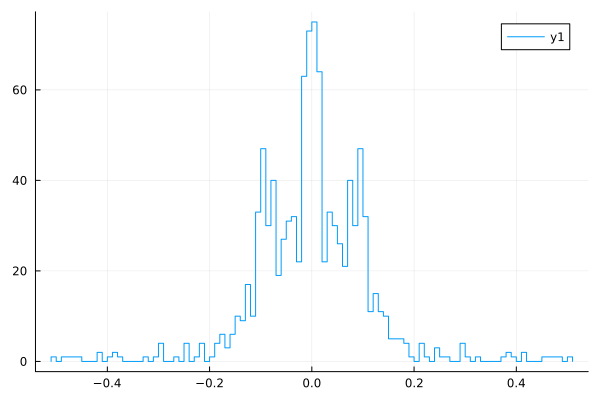

In [66]:
stephist(real.(eigenvalues_2),bins=100)
#stephist!(eigenvalues_2,bins=100)

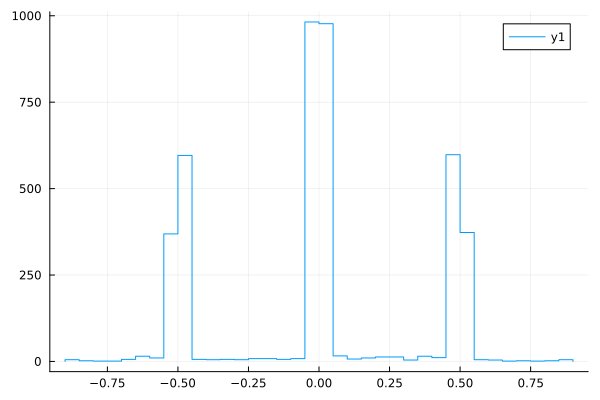

In [36]:
stephist(eigenvalues_1,bins=50)


In [259]:
println((maximum(eigtemp.values)-minimum(eigtemp.values))/2)


3.7000284197963484


In [274]:
maximum(eigtemp.values)

3.4939592074349344

In [275]:
minimum(eigtemp.values)

-3.4939592074349295

In [229]:
find_hopping_norms_sorted_by_distance_average_from_i0(H, L, L, div(L,2), false)

4-element Vector{Vector{Any}}:
 [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 1.0]

In [210]:
maximum(eigenvalues)

9.243821881840312

(3432, 3432)


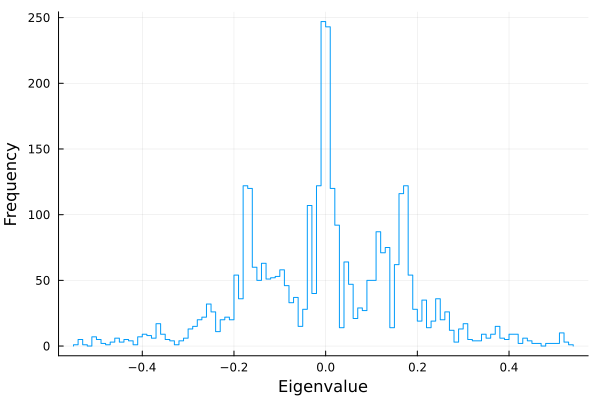

In [164]:
L= 14; # system size
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 10; # disorder strength

d=Uniform(-1,1)
h=W*rand(d, L)


J_mag=0.1
J = J_mag*ones(Float64, L); # interactions

the_map=construct_map_of_n_filling_states(L, div(L,2))

H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
eigtemp=eigen(H_half_filling)

eigtemp=eigen(H_half_filling)
eigenvectors=eigtemp.vectors
println(size(eigenvectors))
N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))

#eigenvalues=eigen(N_R_nodiag'*N_R_nodiag).values
eigtemp_1=eigen(N_R_nodiag)
eigenvalues_1=eigtemp_1.values
eigenvectors_1=eigtemp_1.vectors
#println(sqrt(maximum(abs,eigenvalues)))
#println((maximum(eigenvalues_1)-minimum(eigenvalues_1))/2)

#rintln(sqrt(norm(N_R_nodiag)^2/(binomial(L, div(L,2)))))
#println(eigtemp.values)



stephist(real.(eigenvalues_1), bins=100, xlabel="Eigenvalue", ylabel="Frequency", label=false)


# $N_R$
# $D=\{d_1, d_2, d_3...d_{2^L}\}$
# $\lambda_{max}$
# $\lambda_{min}$
# $\lambda_{min}I \leq N_R+\mathrm{Diag}(D)$
# $N_R+\mathrm{Diag}(D) \leq \lambda_{max}I $

In [60]:
eigenvalues_1

252-element Vector{Float64}:
 -0.1662673624623742
 -0.16624902492071342
 -0.1662131403359606
 -0.1661095408018178
 -0.1660736562170643
 -0.16605531867541218
 -0.15950242379185986
 -0.15936293967296367
 -0.1593446021313124
 -0.15930871754655823
 -0.15620409042799466
 -0.1561682058432324
 -0.15614986830158056
  ⋮
  0.15616820584323252
  0.15620409042798938
  0.15930871754655831
  0.15934460213131488
  0.15936293967295664
  0.1595024237918499
  0.1660553186754145
  0.16607365621704218
  0.1661095408018297
  0.16621314033596013
  0.16624902492072413
  0.16626736246235915

In [122]:
println((maximum(eigenvalues_1)-minimum(eigenvalues_1)))

0.9997981895089807


In [237]:
eigenvalues_1

252-element Vector{Float64}:
 -0.46260964298073337
 -0.2714393757138896
 -0.2638367685802122
 -0.26306270294748624
 -0.2594089730583099
 -0.25801150156118824
 -0.2562768262139808
 -0.2558753148022708
 -0.2549301239662601
 -0.24330670935551957
 -0.24046845444334078
 -0.24014270911029884
 -0.23899325687996348
  ⋮
  0.24229882132896743
  0.24234512220841328
  0.24571363049535802
  0.24989083978872967
  0.25796228124847737
  0.2586801693468822
  0.25883434198725735
  0.2616737800028016
  0.2657783146757623
  0.2660687032360326
  0.28984220936746624
  0.43921831078232243

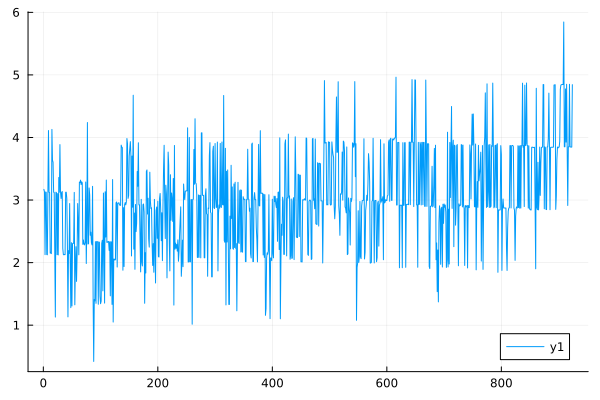

In [134]:
plot([measure_number_particles_right_of_i_0(eigenvectors_1[:,a], the_map, eigenvectors, L, div(L,2)) for a=1:length(eigenvectors_1[:,1])])

In [165]:
eigenvectors_1[:,1]'*get_N_R_operator(L,the_map, div(L,2))*eigenvectors_1[:,1]-eigenvectors_1[:,end]'*get_N_R_operator(L,the_map, div(L,2))*eigenvectors_1[:,end]

0.018850117725843774

In [166]:
println((maximum(eigenvalues_1)-minimum(eigenvalues_1)))

1.0756225540387292


In [168]:
the_first=eigenvectors'*vec(eigenvectors_1[:,1])
the_second=eigenvectors'*vec(eigenvectors_1[:,end])
dot(abs.(the_first), abs.(the_second))

0.9216937576885238

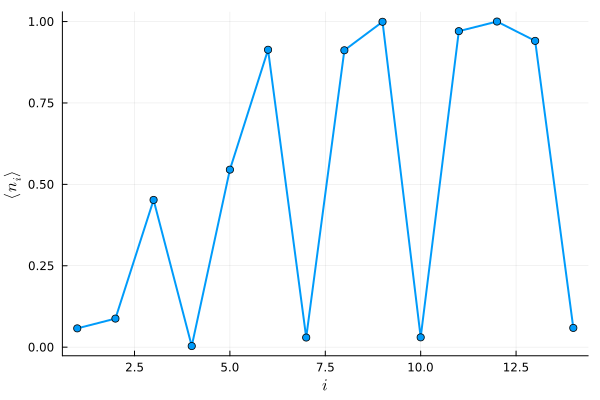

In [169]:
exp_n_1=[eigenvectors_1[:,1]'*get_n_i_operator_half_filling(i, L, the_map)*eigenvectors_1[:,1] for i=1:L]
plot(exp_n_1, xlabel=L"i", ylabel=L"\langle n_i\rangle", linewidth=2, marker=:circle, label="")

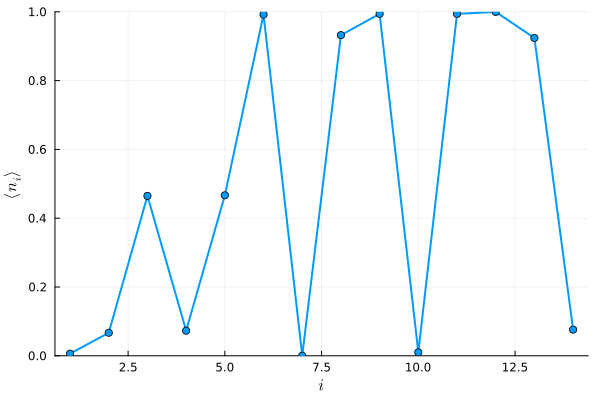

In [173]:
exp_n=[eigenvectors_1[:,end]'*get_n_i_operator_half_filling(i, L, the_map)*eigenvectors_1[:,end] for i=1:L]
plot(exp_n, xlabel=L"i", ylabel=L"\langle n_i\rangle", linewidth=2, marker=:circle, label="", yrange=(0,1))

In [172]:
sum(exp_n)

2.069911390699844

In [110]:
exp_n_1-exp_n

14-element Vector{Float64}:
 -0.08091986892060371
  0.07244997978704626
  0.050987210453833975
  0.07910303500359117
  0.02387214268795046
  0.0072550350909124095
 -0.08978927079190496
  0.09803563119304234
 -0.06844146246222026
 -0.05248135745013449
 -0.006993844818349748
 -0.014688521735175486
 -0.024720642298089672
  0.006331934260106475

In [109]:
exp_n

14-element Vector{Float64}:
 0.4694247233530991
 0.4849952477836904
 0.42354513167408564
 0.2412769114028211
 0.7012211306355339
 0.8199086194382594
 0.3890910987283477
 0.19440741193349773
 0.19083581258761084
 0.6901807480572317
 0.9050376886985984
 0.4364799915778954
 0.07557580489281088
 0.978019679236523

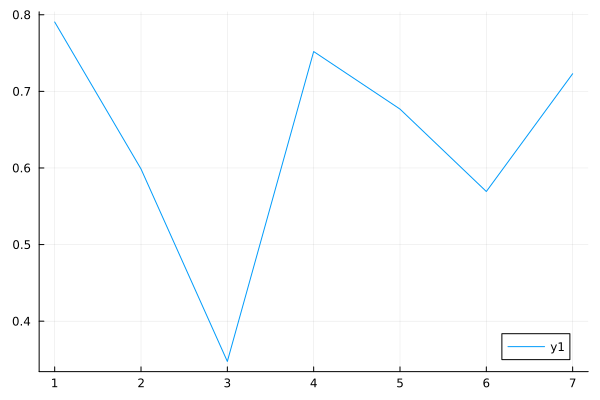

In [156]:
exp_n=[eigenvectors_1[:,end]'*get_n_i_operator_half_filling(i, L, the_map)*eigenvectors_1[:,end] for i=1:div(L,2)]
plot(exp_n)

In [136]:
sum(exp_n)

3.001248372413019

In [143]:
measure_number_particles_right_of_i_0(eigenvectors_1[:,1], the_map, eigenvectors, L, div(L,2))

3.9990616122442137

In [145]:
eigenvectors_1[:,1]'*get_N_R_operator(L,the_map, div(L,2))*eigenvectors_1[:,1]

3.000021598122901

In [137]:
exp_n=[eigenvectors_1[:,1]'*get_n_i_operator_half_filling(i, L, the_map)*eigenvectors_1[:,1] for i=1:div(L,2)]


7-element Vector{Float64}:
 2.566114639694261e-5
 0.5000226577364042
 0.4992531042878047
 0.0014931160590111088
 0.9992162736446519
 0.0007852928502224875
 0.9992254923984121

In [175]:
size(get_n_i_operator_half_filling(1, L, the_map))

(3432, 3432)

In [138]:
sum(exp_n)

3.0000215981229035

In [84]:
function optimize_nr(M)
    A = copy(M)
    n = size(A, 1)
    N_R=get_N_L_operator(L,the_map, div(L,2))
    N_R=eigenvectors'*N_R*eigenvectors
    
    # Decision variables
    d = Variable(size(A, 1)) 
    α = Variable()          # lower eigenvalue bound
    β = Variable()          # upper eigenvalue bound
    t = Variable()          # spread (β - α)
    
    D = diagm(d)
    
    constraints = [
        A + D ⪯ β*I(n),     # largest eigenvalue ≤ β
        α*I(n) ⪯ A + D,     # smallest eigenvalue ≥ α
        t == β - α
    ]
    
    problem = minimize(t, constraints)
    solve!(problem, SCS.Optimizer; silent=true)
    
    # Construct the diagonal matrix D
    D_opt = diagm(Convex.evaluate(d))
    return (Convex.evaluate(t),Convex.evaluate(D))
end

optimize_nr (generic function with 1 method)

(3432, 3432)

In [85]:
t, D=optimize_nr(N_R_nodiag)

(0.817512611035212, [7.305691200167176e-5 0.0 … 0.0 0.0; 0.0 0.00013398203139188935 … 0.0 0.0; … ; 0.0 0.0 … 0.00021835581633406035 0.0; 0.0 0.0 … 0.0 0.00012261128846806398])

In [92]:
eigvals, eigvecs=eigen(N_R_nodiag+(D));
maximum(eigvals)-minimum(eigvals)

0.817759998467003

In [94]:
the_first=eigenvectors'*vec(eigvecs[:,1])
the_second=eigenvectors'*vec(eigvecs[:,end])
dot(abs.(the_first), abs.(the_second))

0.7983660064790361

In [ ]:
Ls=[4,6,8,10]
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 10; # disorder strength

d=Uniform(-1,1)

average_Ms=Float64[]
average_true_Ms=Float64[]

J_mag=0.1
J = J_mag*ones(Float64, L); # interactions

for L in Ls
    println("L=",L)
    the_map=construct_map_of_n_filling_states(L, div(L,2))
    Ms=Float64[]
    true_Ms=Float64[]
    for i=1:1000
        h=W*rand(d, L)
        
        H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")
        eigtemp=eigen(H_half_filling)
        eigenvectors=eigtemp.vectors
        N_R_nodiag=get_N_R_operator_eigenstate_basis(L, the_map, eigenvectors, div(L, 2))
        
        #eigenvalues=eigen(N_R_nodiag'*N_R_nodiag).values
        eigtemp_1=eigen(N_R_nodiag)
        eigenvalues_1=eigtemp_1.values
        #println(sqrt(maximum(abs,eigenvalues)))
        push!(Ms,(maximum(eigenvalues_1)-minimum(eigenvalues_1)))
        push!(true_Ms,optimize_nr(N_R_nodiag))
        
    end
    push!(average_Ms, mean(Ms))
    push!(average_true_Ms, mean(true_Ms))
end


In [310]:
average_Ms

2004-element Vector{Float64}:
   0.3332590804160871
   0.22898168664738094
   0.22005108270124185
   0.9828491357525705
   0.5025934330841589
   0.1749793614759348
   1.2270042391411553
   0.5003175952097907
   0.6140125563906685
   0.5656414262489965
   0.24400910011023308
   0.2373353269936187
   0.20999916163006369
   ⋮
   0.37190509047341824
   1.0299993101780585
   1.1137716276007499
   0.47827314124204634
   1.0221253527307175
   1.5755481228383519
   0.6373910603015294
   1.0483587972627801
   1.3217583491923806
   1.1374102933799226
   1.0406155654565201
 NaN

In [312]:
actual_ms=[average_Ms[1:500],average_Ms[502:1001],average_Ms[1003:1502],average_Ms[1504:2003]]
actual_optimal_ms=[average_true_Ms[1:500],average_true_Ms[502:1001],average_true_Ms[1003:1502],average_true_Ms[1504:2003]]

4-element Vector{Vector{Float64}}:
 [0.33304252852414346, 0.2273758364836499, 0.22003324740235786, 0.9338527293489522, 0.4959200630004987, 0.17470599792846217, 1.0672259607326418, 0.5001570730360934, 0.6135386982769124, 0.5579292500676651  …  0.3076197037598958, 0.2190307480827163, 0.3902394541783739, 0.22770406113101485, 0.33484675365539424, 0.1871864217390769, 1.0075384169351562, 0.6075298540368527, 0.5323293052564014, 0.9275233237189309]
 [0.2760372509164887, 0.9825519214151516, 0.2592346867175161, 0.16688045503089513, 0.6232820945528182, 0.33284624162826754, 0.5652201471073468, 0.9480614078011738, 0.15811816363041073, 0.9920367098912709  …  0.21406134270067834, 0.15672866380520034, 0.4938129125243103, 0.41715475962841486, 0.6159071185107613, 1.330080136392835, 0.2683342676409497, 0.423611010421274, 0.8266528495030065, 0.3840844115776989]
 [0.4031905217428565, 0.6935444749925859, 1.0179119757716282, 0.2074558635804233, 0.2214326275909572, 0.7415034799571659, 1.2330361407270347, 0.87

In [313]:
actual_ms=[mean(a) for a in actual_ms]
actual_optimal_ms=[mean(a) for a in actual_optimal_ms]

4-element Vector{Float64}:
 0.5705050459285547
 0.6509471518913175
 0.6762388632353704
 0.7183685963235161

In [319]:
actual_ms

4-element Vector{Float64}:
 0.5882482334368107
 0.6788770535042459
 0.708011780937091
 0.7551497569948596

In [317]:
actual_ms-actual_optimal_ms

4-element Vector{Float64}:
 0.017743187508255986
 0.02792990161292841
 0.03177291770172064
 0.036781160671343516

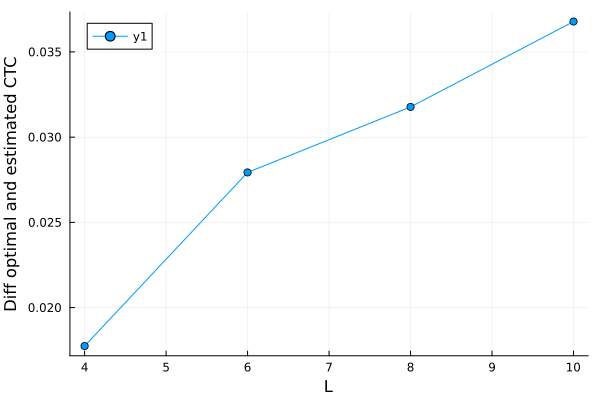

In [325]:
plot(Ls,actual_ms-actual_optimal_ms, marker=:circle, xlabel="L", ylabel="Diff optimal and estimated CTC")
#savefig("difference_optimal_estimated_ctc.png")

In [309]:
(average_Ms[501:1002])

502-element Vector{Float64}:
 NaN
   0.27624688618937365
   0.9871190522333426
   0.25926935666904616
   0.17142233503548326
   0.6336858115326636
   0.3341847139401718
   0.573485430714469
   0.9620931072873569
   0.15853990469391488
   1.0226158029720116
   0.1551092292747716
   0.21136366435987874
   ⋮
   1.3796797902372673
   0.21405435340780912
   0.15685204397766891
   0.5015433019283642
   0.4256638396282964
   0.6173015562250443
   1.3627409319064654
   0.2743358556194968
   0.44062880566918944
   0.8743544821643005
   0.3866540633127242
 NaN

In [267]:
using Convex, LinearAlgebra, SCS

A = N_R_nodiag
n = size(A, 1)
N_R=get_N_L_operator(L,the_map, div(L,2))
N_R=eigenvectors'*N_R*eigenvectors

# Decision variables
d = Variable(size(A, 1)) 
α = Variable()          # lower eigenvalue bound
β = Variable()          # upper eigenvalue bound
t = Variable()          # spread (β - α)

D = diagm(d)

constraints = [
    A + D ⪯ β*I(n),     # largest eigenvalue ≤ β
    α*I(n) ⪯ A + D,     # smallest eigenvalue ≥ α
    t == β - α
]

problem = minimize(t, constraints)
solve!(problem, SCS.Optimizer)

# Construct the diagonal matrix D
D_opt = diagm(Convex.evaluate(d))


[ Info: [Convex.jl] Compilation finished: 0.03 seconds, 31.607 MiB of memory allocated


------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 255, constraints m: 63757
cones: 	  z: primal zero / dual free vars: 1
	  s: psd vars: 63756, ssize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 1011, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 9.78e-02  1.23e+02  2.16e+01  1.08e+01  1.00e-01  3.02e-02 
   250| 1.70e-05  4.96e-04  2.28e-04  2.55

252×252 Matrix{Float64}:
 0.00333199  0.0         0.0         0.0         …   0.0          0.0
 0.0         0.00250149  0.0         0.0             0.0          0.0
 0.0         0.0         0.00433127  0.0             0.0          0.0
 0.0         0.0         0.0         0.00309518      0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0         …   0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0         …   0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 ⋮                                               ⋱   ⋮           

Variable
size: (252, 1)
sign: real
vexity: affine
id: 264…752


LoadError: Value of the variable is yet to be calculated

In [247]:
Convex.evaluate(β)

0.4395222803433102

In [248]:
maximum(eigen(MM).values)

0.4394800447362313

In [271]:
maximum(eigen(A).values)-minimum(eigen(A).values)

0.2552180516477103

In [272]:
M=A-Diagonal(diag(A))
maximum(eigen(M).values)-minimum(eigen(M).values)

0.2552180516477103

In [273]:
MM=Matrix(A) + D_opt
maximum(eigen(MM).values)-minimum(eigen(MM).values)

0.25499669338470854

# Pick $D$ such that $N_R - D$ minimize $\lambda_{max}-\lambda_{min}$

In [340]:
eigtemp_mm=eigen(MM);
stephist(eigtemp_mm.values, bins=100)

the_first=eigenvectors'*vec(eigtemp_mm.vectors[:,1])
the_second=eigenvectors'*vec(eigtemp_mm.vectors[:,end])
dot(the_first, the_second)

2.0886070650760757e-15

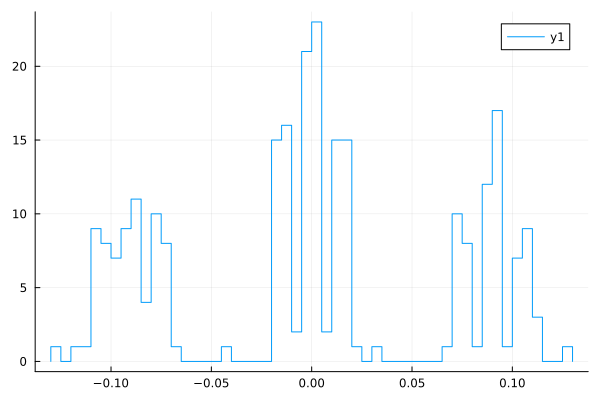

In [288]:
stephist(eigenvalues_1, bins=100)

In [263]:
D_opt

252×252 Matrix{Float64}:
 0.00333199  0.0         0.0         0.0         …   0.0          0.0
 0.0         0.00250149  0.0         0.0             0.0          0.0
 0.0         0.0         0.00433127  0.0             0.0          0.0
 0.0         0.0         0.0         0.00309518      0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0         …   0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0         …   0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 0.0         0.0         0.0         0.0             0.0          0.0
 ⋮                                               ⋱   ⋮           

In [493]:
#append!(x, reverse(copy(x)))
L=10
h=zeros(Float64, L)

pbc=true
bonds=bonds1D(L, false)
H_temp=build_anderson_hamiltonian_1d(h, bonds, L, 1)
eigtemp=eigen(H_temp)
#M_0=(transport_operator(eigtemp.vectors, eigtemp.values,  div(L,2)))
#W=operator_norm(M_0)
println(W)
#println(0.5*norm(M_0))

2.499999999999997


In [494]:
H_temp

10×10 Matrix{Float64}:
  0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0  -1.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0   0.0  -1.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0   0.0  -1.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0

In [495]:
M_0

10×10 Matrix{Float64}:
  0.0         0.428814     0.0       …   0.101405   0.0         -0.0928281
  0.428814    0.0          0.249983      0.0        0.00857738   0.0
  0.0         0.249983     0.0          -0.114866   0.0          0.101405
 -0.178831    0.0          0.373426      0.0       -0.0220375    0.0
  0.0        -0.0553877    0.0           0.156793   0.0         -0.123443
  0.123443    0.0         -0.156793  …   0.0        0.0553877    0.0
  0.0         0.0220375    0.0          -0.373426   0.0          0.178831
  0.101405    0.0         -0.114866      0.0        0.249983     0.0
  0.0         0.00857738   0.0           0.249983   0.0          0.428814
 -0.0928281   0.0          0.101405      0.0        0.428814     0.0

In [496]:
println(eigtemp.values)

[-1.9189859472289927, -1.6825070656623606, -1.3097214678905695, -0.8308300260037713, -0.2846296765465701, 0.2846296765465721, 0.8308300260037735, 1.30972146789057, 1.682507065662362, 1.9189859472289947]


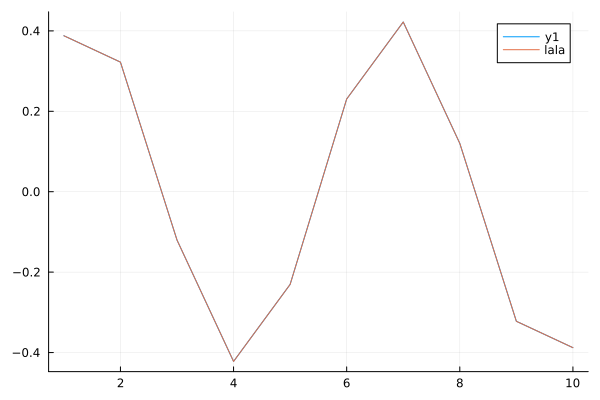

In [518]:
k=4
plot(eigtemp.vectors[:,k])
x=1:10
plot!(1:10, sqrt(2/(L+1))*sin.(k*pi/(L+1) .* x), label="lala")

In [523]:
state_m=zeros(Float64, L)
m=1
for k=1:L
    state_m = state_m .+ eigtemp.vectors[:,k] * eigtemp.vectors[m,k]
end
println(state_m)

[0.9999999999999993, -2.0816681711721685e-16, -6.245004513516506e-17, -7.979727989493313e-16, -5.689893001203927e-16, -4.85722573273506e-17, -1.6653345369377348e-16, -6.245004513516506e-17, 5.204170427930421e-17, 1.5612511283791264e-17]


In [497]:
println([2*cos(pi*k/(L+1)) for k=1:L])

[1.9189859472289947, 1.6825070656623624, 1.3097214678905702, 0.8308300260037729, 0.28462967654657023, -0.28462967654657, -0.8308300260037726, -1.30972146789057, -1.6825070656623622, -1.9189859472289947]


In [474]:
eigtemp

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
8-element Vector{Float64}:
 -1.8793852415718124
 -1.5320888862379518
 -0.9999999999999982
 -0.34729635533386105
  0.34729635533386194
  1.0000000000000004
  1.5320888862379571
  1.8793852415718169
vectors:
8×8 Matrix{Float64}:
 0.16123   -0.303013   0.408248     …  -0.408248     -0.303013   0.16123
 0.303013  -0.464243   0.408248         0.408248      0.464243  -0.303013
 0.408248  -0.408248   2.81013e-15      6.7987e-16   -0.408248   0.408248
 0.464243  -0.16123   -0.408248        -0.408248      0.16123   -0.464243
 0.464243   0.16123   -0.408248         0.408248      0.16123    0.464243
 0.408248   0.408248  -2.53818e-15  …  -6.34545e-16  -0.408248  -0.408248
 0.303013   0.464243   0.408248        -0.408248      0.464243   0.303013
 0.16123    0.303013   0.408248         0.408248     -0.303013  -0.16123

In [469]:
H_temp

8×8 Matrix{Float64}:
  0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   0.0  -1.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   0.0  -1.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0  -1.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0   0.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0

In [472]:
cos(1)

0.5403023058681398

In [533]:
function DCTC_free(L)
    sum=0
    for m=1:div(L,2)
        sum1=0
        for k=1:L
            for kk=1:L
                sum2=0
                for n=1:L
                    sum2+=sin(n*k*pi/(L+1))*sin(n*kk*pi/(L+1))
                end
                sum1+=abs(sum2)*abs(sin(m*k*pi/(L+1))*sin(m*kk*pi/(L+1)))*(2/(L+1))^2
            end
        end
        sum+=sum1
    end
    return sum
end

DCTC_free (generic function with 1 method)

In [534]:
DCTC_free(20)

10.00000000000002

In [687]:
n=2^8
temp=rand(n,n)
temp=temp'*temp


256×256 Matrix{Float64}:
 75.6534  61.3794  56.7284  60.8728  …  56.9443  61.0291  57.36    61.347
 61.3794  85.9348  64.0831  62.7454     62.9897  65.6661  65.4485  65.1795
 56.7284  64.0831  80.5071  60.5755     59.3376  63.3163  62.7301  63.4697
 60.8728  62.7454  60.5755  85.0083     60.4522  65.4123  64.9618  65.8543
 59.3759  63.0011  59.854   61.5535     62.194   64.7503  59.7093  63.7539
 58.0265  62.0121  59.7726  60.4949  …  60.3816  63.4877  64.2641  68.5478
 59.3661  61.2606  61.4962  60.531      59.2834  65.3867  58.7463  66.6538
 59.4874  63.1744  59.1921  61.7029     62.9021  65.6526  60.0985  63.0737
 57.586   62.7758  60.3154  62.2883     61.5127  63.7554  60.1364  65.489
 58.8219  64.859   62.1331  63.725      62.1598  64.8304  61.9102  63.5826
 67.8773  69.4188  66.5328  69.6113  …  67.2322  72.198   70.1829  71.9657
 59.4816  61.7986  59.9582  65.3977     60.9176  67.765   64.3716  66.2503
 62.6972  64.3967  62.4859  64.1559     61.2055  65.8937  65.1276  66.6541
  

In [732]:
L=8
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 0.1; # disorder strength

d=Uniform(-1,1)
h=W*rand(d, L)
J_mag=1
J = J_mag*ones(Float64, L); # interactions
H, max_index=construct_disordered_interacting_hamiltonian_nearest_neighbor(L, J, h, t, false, "full");
max_index = max_index[sortperm(t, rev=true)];

eigtemp=eigen(H)
eigenvectors=eigtemp.vectors

256×256 Matrix{Float64}:
  0.0           0.0           0.0          …   0.0          0.0   0.0
  2.08289e-54   0.0           0.0              0.0          0.0  -2.62869e-91
  8.64701e-54   0.0           0.0              0.0          0.0   1.84021e-90
  9.63306e-22  -1.74306e-25  -4.58126e-19      0.0          0.0  -3.22093e-54
  3.40339e-53   0.0           0.0              0.0          0.0  -1.25729e-89
  4.93062e-21  -8.58941e-25  -1.98355e-18  …   0.0          0.0   1.94335e-53
  5.57454e-21  -9.27105e-25  -1.81252e-18      0.0          0.0  -4.98671e-53
  0.00129414   -1.82542e-20  -0.00630512       8.98711e-22  0.0   1.96152e-43
  1.37535e-52   0.0           0.0              0.0          0.0   8.43686e-89
  1.43524e-20  -2.38154e-24  -4.56775e-18      0.0          0.0  -8.12966e-53
  2.44037e-20  -3.85364e-24  -6.12277e-18  …   0.0          0.0   2.74271e-52
  0.00802863   -1.24845e-19  -0.0341173        4.85474e-21  0.0  -9.70581e-43
  2.08626e-20  -3.04195e-24  -3.45022e-18     -

In [733]:
H * eigtemp.vectors[:,2^8]

256-element Vector{Float64}:
  0.0
 -1.8248688490678414e-90
  1.2774988401878056e-89
 -2.2360118666604596e-53
 -8.728247140254871e-89
  1.3490990939827979e-52
 -3.4618389266505736e-52
  1.3617114411831639e-42
  5.856978704739483e-88
 -5.64371680065103e-52
  1.9040250055413323e-51
 -6.737897217064001e-42
 -4.707313981109068e-51
  ⋮
  1.1394863150862197e-16
 -1.6306901845134413e-15
  2.1463121446568585e-15
  2.5406553397114062
 -2.3415950246591907e-16
  1.7050054545752324e-15
 -2.7762241504856993e-15
 -2.493514463112811
  3.734281271048986e-15
  2.6865791557919056
 -2.8203442717599283
  0.0

In [734]:
H

256×256 Matrix{Float64}:
 0.0   0.0         0.0         0.0       …   0.0      0.0      0.0
 0.0  -0.0583654  -1.0         0.0           0.0      0.0      0.0
 0.0  -1.0        -0.0330092   0.0           0.0      0.0      0.0
 0.0   0.0         0.0         0.908625      0.0      0.0      0.0
 0.0   0.0        -1.0         0.0           0.0      0.0      0.0
 0.0   0.0         0.0        -1.0       …   0.0      0.0      0.0
 0.0   0.0         0.0         0.0           0.0      0.0      0.0
 0.0   0.0         0.0         0.0           0.0      0.0      0.0
 0.0   0.0         0.0         0.0           0.0      0.0      0.0
 0.0   0.0         0.0         0.0           0.0      0.0      0.0
 0.0   0.0         0.0         0.0       …   0.0      0.0      0.0
 0.0   0.0         0.0         0.0           0.0      0.0      0.0
 0.0   0.0         0.0         0.0           0.0      0.0      0.0
 ⋮                                       ⋱                     ⋮
 0.0   0.0         0.0         0.0     

In [735]:
tempp=get_n_i_operator(2, 8)

256×256 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0   

In [738]:
N_R=eigtemp.vectors' * tempp * eigtemp.vectors
N_R=N_R-Diagonal(diag(N_R))

256×256 Matrix{Float64}:
  0.0           2.91794e-16   0.0150225    …   4.67674e-17  0.0   1.42062e-32
  2.91794e-16   0.0          -1.76444e-16     -1.50538e-17  0.0   4.1612e-21
  0.0150225    -1.76444e-16   0.0             -3.19129e-18  0.0  -1.34104e-33
 -2.66335e-16   4.36337e-17  -7.10573e-17     -2.76108e-17  0.0  -2.61563e-32
 -2.66142e-16  -0.098338      1.95235e-16      4.84828e-19  0.0  -3.88696e-20
  0.00902867   -4.45177e-16   0.161328     …   6.44516e-17  0.0   6.57077e-32
 -2.90149e-16  -3.37904e-16   2.47646e-16      3.90509e-18  0.0  -2.86641e-33
 -1.67027e-17   5.4702e-17   -4.02294e-17      4.9963e-17   0.0  -1.17514e-17
 -0.15971       3.25758e-16   0.0694597       -2.57769e-17  0.0  -1.2893e-32
  0.0161747     2.55511e-16   0.111696        -1.41234e-17  0.0  -1.92699e-32
 -1.45422e-16  -2.10319e-16   7.2246e-17   …  -2.39455e-19  0.0  -3.88149e-33
 -1.52416e-16  -0.177655      1.46196e-17      6.53797e-17  0.0  -2.26758e-20
  4.55981e-16  -0.0039063    -4.15802e-16

In [745]:
N_R=reduce(vcat,(N_R))
N_R=N_R[N_R .!= 0]

64262-element Vector{Float64}:
  2.9179356800890004e-16
  0.015022545047929103
 -2.6633479215256195e-16
 -2.661424960106296e-16
  0.009028665010148249
 -2.9014851661455823e-16
 -1.6702683068835137e-17
 -0.15971013591348693
  0.01617471448477055
 -1.4542239894916634e-16
 -1.5241551829898038e-16
  4.559812212093565e-16
 -1.9322022380735287e-16
  ⋮
  0.04705483461106155
  5.355348704220605e-17
 -4.774664600712453e-16
 -3.0033055159573586e-19
 -2.1378718991934822e-16
  3.9839118816077195e-18
  4.439210711841263e-17
 -0.06713944447570236
 -2.827067805452645e-18
 -3.6936967808508126e-16
  0.15008662239633727
  9.989328822740221e-17

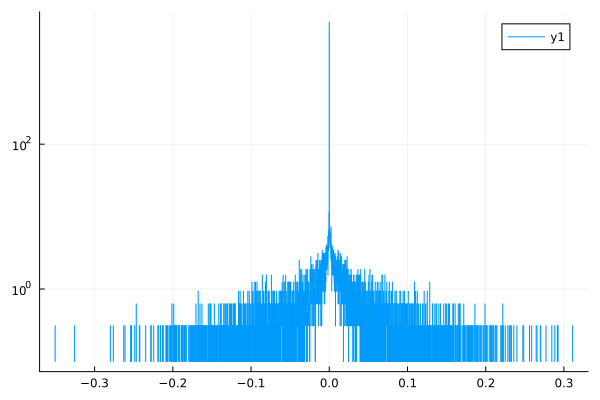

In [750]:
stephist((N_R), norm=true, yaxis=:log)

In [754]:
L=8
T = 1 # random hopping strength
t = T*ones(Float64, L); #hopping
#t = ones(L)
W = 0.1; # disorder strength

d=Uniform(-1,1)
h=W*rand(d, L)
J_mag=1
J = J_mag*ones(Float64, L); # interactions

the_map=construct_map_of_n_filling_states(L, div(L,2))

H_half_filling, max_index_half=construct_disordered_interacting_hamiltonian_nearest_neighbor_half_filling(L, J, h, t,the_map, false, "full")

eigtemp=eigen(H_half_filling)
eigenvectors=eigtemp.vectors

70×70 Matrix{Float64}:
 -0.000444047  -0.00218658  …  -0.0927574  -0.0336268   0.00815393
 -0.00311024   -0.0135024       0.17193     0.0773157  -0.0227698
 -0.00888931   -0.033093       -0.204421   -0.118805    0.0418893
 -0.0122277    -0.0384508       0.192287    0.148769   -0.0606116
 -0.00637603   -0.0175764      -0.158654   -0.154587    0.0685702
 -0.00951621   -0.035355    …  -0.183773   -0.0983071   0.0350322
 -0.0383186    -0.120358        0.212612    0.162104   -0.0741527
 -0.0593707    -0.152144       -0.166485   -0.202624    0.113377
 -0.0324107    -0.0700268       0.102312    0.207174   -0.131099
 -0.0420013    -0.0978103      -0.115385   -0.140797    0.0863151
 -0.0985636    -0.179231    …   0.0288124   0.175048   -0.146585
 -0.0603579    -0.0842112       0.0602281  -0.171591    0.176034
 -0.0533689    -0.0577713       0.103695   -0.0872135   0.13118
  ⋮                         ⋱                          
 -0.11651       0.131306       -0.0547921   0.0792342   0.0744794
 -

In [758]:
tempp=get_n_i_operator_half_filling(2, L, the_map)
N_R=eigtemp.vectors' * tempp * eigtemp.vectors
N_R=N_R-Diagonal(diag(N_R))

70×70 Matrix{Float64}:
  0.0         -0.10803       0.178992     …  -1.43853e-7    1.59093e-8
 -0.10803      0.0          -0.0526572        2.18652e-6    4.37598e-7
  0.178992    -0.0526572     0.0              1.19708e-5    3.22489e-7
 -0.0254789    0.0515246    -0.0905263       -1.28681e-5    1.86039e-6
  0.189423    -0.030328     -0.0551271       -3.20051e-5   -1.35244e-6
 -0.156635    -0.037153     -0.0765577    …   0.000142594  -6.59121e-6
  0.0358785   -0.0879725     0.103166        -4.52021e-5    4.7399e-6
 -0.113934     0.0135659     0.0382712       -3.57987e-5   -4.01102e-6
 -0.0553178   -0.0688709     0.040348        -0.00010645    5.22239e-6
  0.237553    -0.000219368   0.0926716        0.000422275  -8.84975e-6
  0.00134778   0.226855      0.118396     …   0.000422563   0.000274801
 -0.0138252    0.0160676    -0.0526376       -6.7278e-5     7.87069e-6
 -0.17957     -0.00825066   -0.0508           0.000491754  -3.32379e-6
  ⋮                                       ⋱           

In [759]:
N_R_vec=reduce(vcat,(N_R))
N_R_vec=N_R[N_R .!= 0]

4830-element Vector{Float64}:
 -0.10803018911419192
  0.1789918650231416
 -0.025478921861452973
  0.1894231872796757
 -0.15663499885090687
  0.035878507868945815
 -0.11393407569699619
 -0.05531782387917107
  0.23755337518570424
  0.0013477790717027608
 -0.01382522106414928
 -0.17957012175985443
  0.019265379735589467
  ⋮
 -0.20290439333751442
 -0.023417236842549892
 -0.06726364339061505
  0.08694920493820685
  0.007662565934374015
  0.08037951330739092
 -0.03981268006929378
 -0.05341958947699667
 -0.05702583659317004
  0.03928747746645433
  0.020677388926580838
 -0.08624009500648644

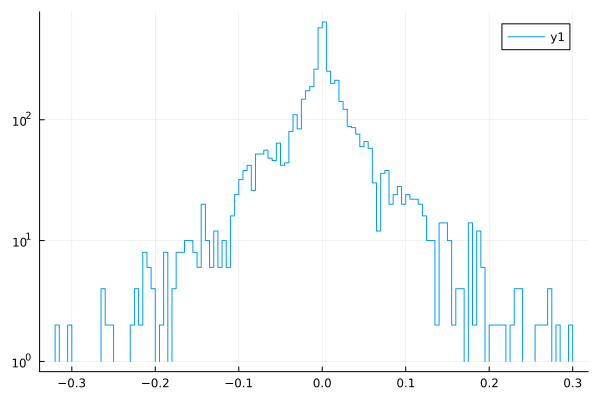

In [761]:
stephist(N_R_vec, yaxis=:log)

In [762]:
norm(N_R_vec)

4.11831552327602

# $\phi_{max}=\sum_n c_n \psi_n$
# $\phi_{min}=\sum_n b_n \psi_n$
# $\sum_n b_n^* c_n \approx 1?$

# $\langle \phi_{max} | N_R | \phi_{max} \rangle - \langle \phi_{min} | N_R | \phi_{min} \rangle =\langle \phi_{max} | \hat M | \phi_{max} \rangle - \langle \phi_{min} | \hat M | \phi_{min} \rangle$

# Check:

# $\langle \phi_{max} | \hat M | \phi_{max} \rangle - \langle \phi_{min} | \hat M | \phi_{min} \rangle$
# $= \langle \phi_{max} | N_R | \phi_{max} \rangle - \langle \phi(0) | \hat N_R | \phi_{min} \rangle - \langle \phi_{max} | D | \phi_{max} \rangle + \langle \phi_{min} | D | \phi_{min} \rangle$

# If $\phi_{min}=e^{-iHt} \phi_{max}$ then 

# $= \langle \phi_{max} | N_R | \phi_{max} \rangle - \langle \phi(0) | \hat N_R | \phi_{min} \rangle - \langle \phi_{max} | D | \phi_{max} \rangle + \langle e^{-iHt} \phi_{max} | D | e^{-iHt} \phi_{max} \rangle$

# But because D is diagonal WRT the Hamiltonian by construction, it must be that

# $\langle e^{-iHt} \phi_{max} | D | e^{-iHt} \phi_{max} \rangle = \langle \phi_{max} | D | \phi_{max} \rangle$
